# Ames Housing Prices

Team Members: Sean Godfrey | Sai Kalva | Fernando Salazar | Katrina Li | Ben Wilson

In the code below, our team aims to develop a model to predict house prices based on the features of houses available in Ames, Iowa. We will then compete as a team in the associated Kaggle competition. 

The Kaggle competition and data may be found using the following link: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

## Import Packages

To begin the data model process, our team will import all necessary packages to notebook.

In [1]:
#import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import dill
import statsmodels.formula.api as smf

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, f1_score, confusion_matrix, RocCurveDisplay
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error, make_scorer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor

from patsy import dmatrices, dmatrix, build_design_matrices, demo_data

# Set number of CPU cores for parallel algorithms
import os
if "CPU_LIMIT" in os.environ:
    # If you are on JupyterHub, this gives you the right number of CPUs for your virtual machine
    num_cpus = int(os.getenv("CPU_LIMIT").split('.')[0])
else:
    # If you are not on JupyterHub, this gives you the right number for your computer.
    num_cpus = os.cpu_count()

The below code parameters is not in itself a imported library, but helps to format plots within the code.

In [2]:
# This sets some nicer defaults for plotting.
# This must be run in a separate cell from importing matplotlib due to a bug.
params = {'legend.fontsize': 'large',
          'figure.figsize': (11.0, 11.0),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
mpl.rcParams.update(params)

# This makes it so that the pandas dataframes don't get truncated horizontally.
pd.options.display.max_columns = 200

## Load Data

We first have to load the raw test and train data from Kaggle. We will read it in as a Pandas "dataframe" to store and manipulate the data in a structured format, similar to a spreadsheet.

We can reference the train data set "train.csv" as `train`and the test set "test.csv" as `test`.

In [3]:
#load for local account
train = pd.read_csv(r'C:\Users\brwil\Desktop\Darden\SY Q2 Darden\8496 - Data Science in Business\Final\train.csv')
test = pd.read_csv(r'C:\Users\brwil\Desktop\Darden\SY Q2 Darden\8496 - Data Science in Business\Final\test.csv')

Once the data is loaded, we run the `.head()` function to view each in order to receive a better understanding of its structure and the `.shape()` function to view number of rows and columns (ideally the number of columns is the same across each data set).

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
train.shape

(1460, 81)

In [7]:
test.shape

(1459, 80)

## Summarize data

Below we define a summary function which will be used throughout the modeling process to monitor the data columns, specifically the null or missing values as it will cause issues in our predictions later if they remain.

In [8]:
def summarize_dataframe(df):
    """Summarize a dataframe, and report missing values."""
    missing_values = pd.DataFrame({'Variable Name': df.columns,
                                   'Data Type': df.dtypes,
                                   'Missing Values': df.isnull().sum(),
                                   'Unique Values': [df[name].nunique() for name in df.columns]}
                                 ).set_index('Variable Name')
    with pd.option_context("display.max_rows", 1000):
        display(pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna(""))

In [9]:
summarize_dataframe(train)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,int64,0,1460,1460.0,,,,730.5,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,int64,0,15,1460.0,,,,56.89726,42.300571,20.0,20.0,50.0,70.0,190.0
MSZoning,object,0,5,1460.0,5,RL,1151,,,,,,,
LotFrontage,float64,259,110,1201.0,,,,70.049958,24.284752,21.0,59.0,69.0,80.0,313.0
LotArea,int64,0,1073,1460.0,,,,10516.828082,9981.264932,1300.0,7553.5,9478.5,11601.5,215245.0
Street,object,0,2,1460.0,2,Pave,1454,,,,,,,
Alley,object,1369,2,91.0,2,Grvl,50,,,,,,,
LotShape,object,0,4,1460.0,4,Reg,925,,,,,,,
LandContour,object,0,4,1460.0,4,Lvl,1311,,,,,,,
Utilities,object,0,2,1460.0,2,AllPub,1459,,,,,,,


It is clear that there are a number of null values. This can be due to a lack of the features existence (ex. no garage attached to the house) or simply due to bad data. Additionally there are many similar features, such as the seven features to describe aspects of the garage. This lends itself to an opportunity for consolidation which will be the next series of code we develop in data cleaning.

## Data cleaning

Prior to performing any data cleaning, we make a copy of the training data set. This is to avoid any issues if we incorrectly manipulate the data or wish to compare back to the original data to avoid incorrectly losing data.

In [10]:
train_clean = train.copy()

In [11]:
train_clean.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


First action to take is to move `Sale Price` to the front of the data set. We will be performing considerable manipulation in this data set for cleaning purposes so it will be helpful to begin arranging the label, continious features, and discrete features together as similar manipulation will be performed across the groups.

In [12]:
#move sale price to beginning of data set
train_clean = train_clean[['SalePrice'] + train_clean.columns[:-1].to_list()]

Eventually we wish to perform regression against the data to predict house prices which will not work with categorical variables. As such, we will map the categorical features to a numeric input. You can see in the data that there is slight inconsistency in the capitalization used for the categorical features - this has been factored into our mapping identified in qual_list.

In [13]:
#map categorical columns as numeric input
qual_list = {
    'Po': 1, 'Fa': 2,
    'PO' : 1, 'FA' : 2,
    'TA': 3, 'Gd': 4, 'Ex': 5
}
train_clean.GarageCond = train_clean.GarageCond.replace(pd.Series(qual_list).astype(str), regex=True)
train_clean.ExterQual = train_clean.ExterQual.replace(pd.Series(qual_list).astype(str), regex=True)
train_clean.ExterCond = train_clean.ExterCond.replace(pd.Series(qual_list).astype(str), regex=True)
train_clean.GarageQual = train_clean.GarageQual.replace(pd.Series(qual_list).astype(str), regex=True)
train_clean.GarageCond = train_clean.GarageCond.replace(pd.Series(qual_list).astype(str), regex=True)
train_clean.KitchenQual = train_clean.KitchenQual.replace(pd.Series(qual_list).astype(str), regex=True)
train_clean.HeatingQC = train_clean.HeatingQC.replace(pd.Series(qual_list).astype(str), regex=True)
train_clean.BsmtQual = train_clean.BsmtQual.replace(pd.Series(qual_list).astype(str), regex=True)
train_clean.BsmtCond = train_clean.BsmtCond.replace(pd.Series(qual_list).astype(str), regex=True)

Next we will fil in those columns for `CentralAir` and `PoolArea` where a null value means that it does not exist. So a null value for pool simply means that no pool exists. Where one exists though we will replace the content with a 1 to make the later regression work easier.

In [14]:
#property has central air
train_clean['CentralAir'] = np.where(train_clean['CentralAir']!= 'Y', 1, 0)

#property has pool
train_clean['Pool'] = np.where(train_clean['PoolArea'] > 0, 1, 0)

We will continue this theme with additional features that, if null, indicates a lack of existence. Once we enter a 1 and 0, the columns will be converted to integer type so that our regression function correctly views them as a number.

In [15]:
#replace nan with 0 indicating it does not exist OR prior to replacing with mean
train_clean.ExterQual = train_clean.ExterQual.fillna(0)
train_clean.ExterCond = train_clean.ExterCond.fillna(0)
train_clean.GarageQual = train_clean.GarageQual.fillna(0)
train_clean.GarageCond = train_clean.GarageCond.fillna(0)
train_clean.KitchenQual = train_clean.KitchenQual.fillna(0)
train_clean.HeatingQC = train_clean.HeatingQC.fillna(0)
train_clean.BsmtQual = train_clean.BsmtQual.fillna(0)
train_clean.BsmtCond = train_clean.BsmtCond.fillna(0)

#convert columns to int
train_clean.ExterQual = train_clean.ExterQual.astype(str).astype(int)
train_clean.ExterCond = train_clean.ExterCond.astype(str).astype(int)
train_clean.GarageQual = train_clean.GarageQual.astype(str).astype(int)
train_clean.GarageCond = train_clean.GarageCond.astype(str).astype(int)
train_clean.KitchenQual = train_clean.KitchenQual.astype(str).astype(int)
train_clean.HeatingQC = train_clean.HeatingQC.astype(str).astype(int)
train_clean.BsmtQual = train_clean.BsmtQual.astype(str).astype(int)
train_clean.BsmtCond = train_clean.BsmtCond.astype(str).astype(int)
train_clean.CentralAir = train_clean.CentralAir.astype(str).astype(int)

#replace select columns with mean as it is in house and exists
train_clean.KitchenQual=train_clean.KitchenQual.replace(0,train_clean.KitchenQual.mean())
train_clean.HeatingQC=train_clean.HeatingQC.replace(0,train_clean.HeatingQC.mean())


We now wish to investigate columns for consolidation. We have a number of columns for both quality and condition for the same house attribute so we will consolidate. This should assist our model as it has fewer attributes to split on (for tree models) and reduces potential issues with multicolinearity between features. Let's go ahead and consolidate some of the features for garage, kitchen, external, square footage, basement, bathroom, and porch. As we consolidate the columns, we will drop the prior columns used to create the newly consolidated feature.

In [16]:
#consolidate garage and remove old columns
train_clean['GarageGrade'] = train_clean.GarageQual * train_clean.GarageCond
train_clean = train_clean.drop('GarageQual', axis=1)
train_clean = train_clean.drop('GarageCond', axis=1)

#consolidate kitchen and remove old columns
train_clean.KitchenQual=train_clean.KitchenQual.replace(0,train_clean.KitchenQual.mean())
train_clean['KitchenScore'] = train_clean.KitchenAbvGr * train_clean.KitchenQual
train_clean = train_clean.drop('KitchenAbvGr', axis=1)
train_clean = train_clean.drop('KitchenQual', axis=1)

#consolidate extergrade and remove old columns
train_clean['ExterGrade'] = train_clean.ExterQual * train_clean.ExterCond
train_clean = train_clean.drop('ExterQual', axis=1)
train_clean = train_clean.drop('ExterCond', axis=1)

#consolidate area
train_clean['FinalArea'] = train_clean['1stFlrSF'] + train_clean['2ndFlrSF'] + train_clean.TotalBsmtSF + train_clean.GrLivArea
train_clean = train_clean.drop('1stFlrSF', axis=1)
train_clean = train_clean.drop('2ndFlrSF', axis=1)
train_clean = train_clean.drop('TotalBsmtSF', axis=1)
train_clean = train_clean.drop('GrLivArea', axis=1)

#consolidate quality and remove old columns
train_clean['QC'] = train_clean.OverallCond * train_clean.OverallQual
train_clean = train_clean.drop('OverallCond', axis=1)
train_clean = train_clean.drop('OverallQual', axis=1)

#consolidate bathroom and remove old columns
train_clean['BR'] = train_clean.BsmtFullBath + (0.5 * train_clean.BsmtHalfBath) + train_clean.FullBath + (0.5 * train_clean.HalfBath)
train_clean = train_clean.drop('BsmtFullBath', axis=1)
train_clean = train_clean.drop('BsmtHalfBath', axis=1)
train_clean = train_clean.drop('FullBath', axis=1)
train_clean = train_clean.drop('HalfBath', axis=1)

#consolidate porch and remove old columns
train_clean['Porch'] = train_clean.OpenPorchSF + train_clean.EnclosedPorch + train_clean['3SsnPorch'] + train_clean.ScreenPorch + train_clean.WoodDeckSF
train_clean = train_clean.drop('OpenPorchSF', axis=1)
train_clean = train_clean.drop('EnclosedPorch', axis=1)
train_clean = train_clean.drop('3SsnPorch', axis=1)
train_clean = train_clean.drop('ScreenPorch', axis=1)
train_clean = train_clean.drop('WoodDeckSF', axis=1)

#consolidate basement quality and remove old columns
train_clean['Bsmt_QC'] = train_clean.BsmtCond * train_clean.BsmtQual
train_clean = train_clean.drop('BsmtCond', axis=1)
train_clean = train_clean.drop('BsmtQual', axis=1)

Although not an issue yet, let's make sure that if any nan values appear they are labeled as mean so not to move our calculations.

In [17]:
#replace NA values with 0 (not existent)
train_clean['GarageCars'].fillna(value=train_clean['GarageCars'].mean(), inplace=True)
train_clean['BsmtUnfSF'].fillna(value=train_clean['BsmtUnfSF'].mean(), inplace=True)
train_clean['LotFrontage'].fillna(value=train_clean['LotFrontage'].mean(), inplace=True)
train_clean['GarageArea'].fillna(value=train_clean['GarageArea'].mean(), inplace=True)
train_clean['MasVnrArea'].fillna(value=train_clean['MasVnrArea'].mean(), inplace=True)

#replace select columns with mean as it is in house and exists
train_clean.FinalArea=train_clean.FinalArea.replace(0,train_clean.FinalArea.mean())
train_clean.BR=train_clean.BR.replace(0,train_clean.BR.mean())

Multicolinearity can cause serious issues with the regression outputs! Let's go ahead and remove those columns that currently have a high mode, meaning they repeat the same values often OR are highly correlated with existing features within the data.

In [18]:
#remove high mode or not applicable features
train_clean = train_clean.drop('Street', axis=1)
train_clean = train_clean.drop('Alley', axis=1)
train_clean = train_clean.drop('Utilities', axis=1)
train_clean = train_clean.drop('Condition2', axis=1)
train_clean = train_clean.drop('RoofMatl', axis=1)
train_clean = train_clean.drop('Heating', axis=1)
train_clean = train_clean.drop('CentralAir', axis=1)
train_clean = train_clean.drop('Electrical', axis=1)
train_clean = train_clean.drop('LowQualFinSF', axis=1)
train_clean = train_clean.drop('Functional', axis=1)
train_clean = train_clean.drop('PavedDrive', axis=1)
train_clean = train_clean.drop('MiscVal', axis=1)
train_clean = train_clean.drop('MiscFeature', axis=1)

`GarageYrBlt` has nan values which could cause issues. Additionally, python is not reading it as an integer value. Year could certainly be a discrete value but for the sake of simplicity with the regression, let us code it as a integer. For those houses without a year built, we will input a mean of all years in the data.

In [19]:
#clean up Garage Year Built
train_clean['GarageYrBlt'].fillna(value=train_clean['GarageYrBlt'].mean(), inplace=True)
train_clean.GarageYrBlt = train_clean.GarageYrBlt.astype(int)

We will need ID in the test data when submitting our predictions but for the train data it will only cause issues with our model training. We will remove it from this cleaned data set.

In [20]:
#remove ID
train_clean = train_clean.drop('Id', axis=1)

For the remaining nan values appearing in categorical features, we will tell python None. We will sort how the regressor deals with categorical features in the encoding step after data cleaning.

In [21]:
#deal with remaining NaN values
train_clean['MasVnrType'] = train_clean['MasVnrType'].fillna('None')
train_clean['BsmtExposure'] = train_clean['BsmtExposure'].fillna('None')
train_clean['BsmtFinType1'] = train_clean['BsmtFinType1'].fillna('None')
train_clean['BsmtFinType2'] = train_clean['BsmtFinType2'].fillna('None')
train_clean['FireplaceQu'] = train_clean['FireplaceQu'].fillna('None')
train_clean['GarageType'] = train_clean['GarageType'].fillna('None')
train_clean['GarageFinish'] = train_clean['GarageFinish'].fillna('None')
train_clean['PoolQC'] = train_clean['PoolQC'].fillna('None')
train_clean['Fence'] = train_clean['Fence'].fillna('None')

In [22]:
summarize_dataframe(train_clean)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
SalePrice,int64,0,663,1460.0,,,,180921.19589,79442.502883,34900.0,129975.0,163000.0,214000.0,755000.0
MSSubClass,int64,0,15,1460.0,,,,56.89726,42.300571,20.0,20.0,50.0,70.0,190.0
MSZoning,object,0,5,1460.0,5,RL,1151,,,,,,,
LotFrontage,float64,0,111,1460.0,,,,70.049958,22.024023,21.0,60.0,70.049958,79.0,313.0
LotArea,int64,0,1073,1460.0,,,,10516.828082,9981.264932,1300.0,7553.5,9478.5,11601.5,215245.0
LotShape,object,0,4,1460.0,4,Reg,925,,,,,,,
LandContour,object,0,4,1460.0,4,Lvl,1311,,,,,,,
LotConfig,object,0,5,1460.0,5,Inside,1052,,,,,,,
LandSlope,object,0,3,1460.0,3,Gtl,1382,,,,,,,
Neighborhood,object,0,25,1460.0,25,NAmes,225,,,,,,,


## Scale continuous features

As is apparent with this data, our continuous features have entirely different scales - simply comparing house prices and fireplaces will represent magnitudes of difference. Python will try to compare these very different features if we do not perform standardization across to scale them. Effectively this can be thought of as trying to compare apples to oranges without a scaler.

Utilizing the standard scaler or Z-score normalization we rescale select features to demonstrate the properties of a Gaussian (Normal) distribution (i.e. mean=0, variance=1). In order to perform the scaling, first let us identify the features to be scaled and train the scaler on those features.

In [23]:
continuous_features = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", 
                            "BsmtUnfSF", "BedroomAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageArea", "PoolArea", "FinalArea"]

In [24]:
scaler = StandardScaler()
scaler.fit(train_clean[continuous_features])

StandardScaler()

Once the scaler has been fit on the features we chose, we transform the features using the standardization then view the data to verify it worked properly.

In [25]:
train_clean[continuous_features] = scaler.transform(train_clean[continuous_features])

In [26]:
train_clean[continuous_features] = scaler.transform(train_clean[continuous_features])

In [27]:
train_clean.head()

,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,Foundation,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,HeatingQC,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PoolArea,PoolQC,Fence,MoSold,YrSold,SaleType,SaleCondition,Pool,GarageGrade,KitchenScore,ExterGrade,FinalArea,QC,BR,Porch,Bsmt_QC
0,208500,60,RL,-3.192124,-1.054039,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,2003,2003,Gable,VinylSd,VinylSd,BrkFace,-0.571577,PConc,No,GLQ,-0.971756,Unf,-0.290443,-1.286314,5,-3.314119,-3.449946,-2.427265,None,Attchd,2003,RFn,2,-2.211321,-0.070402,None,None,2,2008,WD,Normal,0,9,4,12,-3.126184,35,3.5,61,12
1,181500,20,RL,-3.161179,-1.054027,Reg,Lvl,FR2,Gtl,Veenker,Feedr,1Fam,1Story,1976,1976,Gable,MetalSd,MetalSd,None,-0.577593,CBlock,Gd,ALQ,-0.970448,Unf,-0.290443,-1.285627,5,-3.314119,-4.207495,-0.019426,TA,Attchd,1976,RFn,2,-2.213247,-0.070402,None,None,5,2007,WD,Normal,0,9,3,9,-3.126472,48,2.5,298,12
2,223500,60,RL,-3.185935,-1.054011,IR1,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,2001,2002,Gable,VinylSd,VinylSd,BrkFace,-0.572621,PConc,Mn,GLQ,-0.972814,Unf,-0.290443,-1.284859,5,-3.314119,-4.207495,-0.019426,TA,Attchd,2001,RFn,2,-2.210007,-0.070402,None,None,9,2008,WD,Normal,0,9,4,12,-3.126058,35,3.5,42,12
3,140000,70,RL,-3.202439,-1.054028,IR1,Lvl,Corner,Gtl,Crawfor,Norm,1Fam,2Story,1915,1970,Gable,Wd Sdng,Wd Shng,None,-0.577593,BrkTil,No,ALQ,-0.974113,Unf,-0.290443,-1.284315,4,-3.314119,-3.828720,-0.019426,Gd,Detchd,1998,Unf,3,-2.209263,-0.070402,None,None,2,2006,WD,Abnorml,0,9,4,9,-3.126235,35,2.0,307,12
4,250000,60,RL,-3.152927,-1.053980,IR1,Lvl,FR2,Gtl,NoRidge,Norm,1Fam,2Story,2000,2000,Gable,VinylSd,VinylSd,BrkFace,-0.566851,PConc,Av,GLQ,-0.972001,Unf,-0.290443,-1.284571,5,-1.810445,-3.071172,-0.019426,TA,Attchd,2000,RFn,3,-2.205016,-0.070402,None,None,12,2008,WD,Normal,0,9,4,12,-3.125442,40,3.5,276,12


## Arrange columns

As we referenced at the beginning, this would become much easier for manipulating the data if the continuous and categorical features were grouped with the label (`SalePrice`) at the front of the data. We will do so next.

In [28]:
#categorize columns in continuous, categorical, y

cont_col = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1','BsmtFinSF2', 
            'BsmtUnfSF', 'BedroomAbvGr', 'TotRmsAbvGrd','Fireplaces', 'GarageArea', 
            'PoolArea','FinalArea', 'GarageCars','MoSold','GarageGrade','KitchenScore',
            'ExterGrade','QC','BR','Porch','Bsmt_QC']

cat_col = ['MSSubClass', 'MSZoning', 'LotShape', 'LandContour','LotConfig', 
           'LandSlope', 'Neighborhood', 'Condition1','BldgType', 'HouseStyle', 
           'YearBuilt','YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd',
           'MasVnrType', 'Foundation', 'BsmtExposure', 'BsmtFinType1',
           'BsmtFinType2','HeatingQC', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
           'GarageFinish','PoolQC','Fence','YrSold','SaleType','SaleCondition','Pool']

y_col = ['SalePrice']



In [29]:
#rearrange columns
train_clean = train_clean.reindex(['SalePrice','LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1','BsmtFinSF2', 
                                   'BsmtUnfSF', 'BedroomAbvGr', 'TotRmsAbvGrd','Fireplaces', 'GarageArea', 
                                   'PoolArea','FinalArea', 'GarageCars','MoSold','GarageGrade','KitchenScore',
                                   'ExterGrade','QC','BR','Porch','Bsmt_QC','MSSubClass', 'MSZoning', 'LotShape', 'LandContour','LotConfig', 
                                   'LandSlope', 'Neighborhood', 'Condition1','BldgType', 'HouseStyle', 
                                   'YearBuilt','YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd',
                                   'MasVnrType', 'Foundation', 'BsmtExposure', 'BsmtFinType1',
                                   'BsmtFinType2','HeatingQC', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
                                   'GarageFinish','PoolQC','Fence','YrSold','SaleType','SaleCondition','Pool'], 
                                  axis = 1)

In [30]:
train_clean.head()

,SalePrice,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,PoolArea,FinalArea,GarageCars,MoSold,GarageGrade,KitchenScore,ExterGrade,QC,BR,Porch,Bsmt_QC,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,PoolQC,Fence,YrSold,SaleType,SaleCondition,Pool
0,208500,-3.192124,-1.054039,-0.571577,-0.971756,-0.290443,-1.286314,-3.314119,-3.449946,-2.427265,-2.211321,-0.070402,-3.126184,2,2,9,4,12,35,3.5,61,12,60,RL,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,2003,2003,Gable,VinylSd,VinylSd,BrkFace,PConc,No,GLQ,Unf,5,None,Attchd,2003,RFn,None,None,2008,WD,Normal,0
1,181500,-3.161179,-1.054027,-0.577593,-0.970448,-0.290443,-1.285627,-3.314119,-4.207495,-0.019426,-2.213247,-0.070402,-3.126472,2,5,9,3,9,48,2.5,298,12,20,RL,Reg,Lvl,FR2,Gtl,Veenker,Feedr,1Fam,1Story,1976,1976,Gable,MetalSd,MetalSd,None,CBlock,Gd,ALQ,Unf,5,TA,Attchd,1976,RFn,None,None,2007,WD,Normal,0
2,223500,-3.185935,-1.054011,-0.572621,-0.972814,-0.290443,-1.284859,-3.314119,-4.207495,-0.019426,-2.210007,-0.070402,-3.126058,2,9,9,4,12,35,3.5,42,12,60,RL,IR1,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,2001,2002,Gable,VinylSd,VinylSd,BrkFace,PConc,Mn,GLQ,Unf,5,TA,Attchd,2001,RFn,None,None,2008,WD,Normal,0
3,140000,-3.202439,-1.054028,-0.577593,-0.974113,-0.290443,-1.284315,-3.314119,-3.828720,-0.019426,-2.209263,-0.070402,-3.126235,3,2,9,4,9,35,2.0,307,12,70,RL,IR1,Lvl,Corner,Gtl,Crawfor,Norm,1Fam,2Story,1915,1970,Gable,Wd Sdng,Wd Shng,None,BrkTil,No,ALQ,Unf,4,Gd,Detchd,1998,Unf,None,None,2006,WD,Abnorml,0
4,250000,-3.152927,-1.053980,-0.566851,-0.972001,-0.290443,-1.284571,-1.810445,-3.071172,-0.019426,-2.205016,-0.070402,-3.125442,3,12,9,4,12,40,3.5,276,12,60,RL,IR1,Lvl,FR2,Gtl,NoRidge,Norm,1Fam,2Story,2000,2000,Gable,VinylSd,VinylSd,BrkFace,PConc,Av,GLQ,Unf,5,TA,Attchd,2000,RFn,None,None,2008,WD,Normal,0


In [31]:
summarize_dataframe(train_clean)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
SalePrice,int64,0,663,1460.0,,,,180921.19589,79442.502883,34900.0,129975.0,163000.0,214000.0,755000.0
LotFrontage,float64,0,111,1460.0,,,,-3.181706,0.045436,-3.282897,-3.202439,-3.181706,-3.163242,-2.680494
LotArea,float64,0,1073,1460.0,,,,-1.054018,0.0001,-1.05411,-1.054048,-1.054028,-1.054007,-1.051961
MasVnrArea,float64,0,328,1460.0,,,,-0.57441,0.005542,-0.577593,-0.577593,-0.577593,-0.572552,-0.528487
BsmtFinSF1,float64,0,637,1460.0,,,,-0.973018,0.002194,-0.975152,-0.975152,-0.973307,-0.971726,-0.948002
BsmtFinSF2,float64,0,144,1460.0,,,,-0.288653,0.006203,-0.290443,-0.290443,-0.290443,-0.290443,-0.233764
BsmtUnfSF,float64,0,780,1460.0,,,,-1.284176,0.002265,-1.287083,-1.28594,-1.284636,-1.282942,-1.27511
BedroomAbvGr,float64,0,8,1460.0,,,,-3.514952,1.226664,-7.825139,-4.817792,-3.314119,-3.314119,4.204249
TotRmsAbvGrd,float64,0,12,1460.0,,,,-4.011362,0.615657,-5.722593,-4.586269,-4.207495,-3.82872,-1.1773
Fireplaces,float64,0,4,1460.0,,,,-0.951226,1.552253,-2.427265,-2.427265,-0.019426,-0.019426,4.796253


After performing a handful of data cleaning and removal of features due to moltincolinearity, let us perform a correlation with all features against `SalePrice` to see which may prove most helpful in our analysis moving forward.

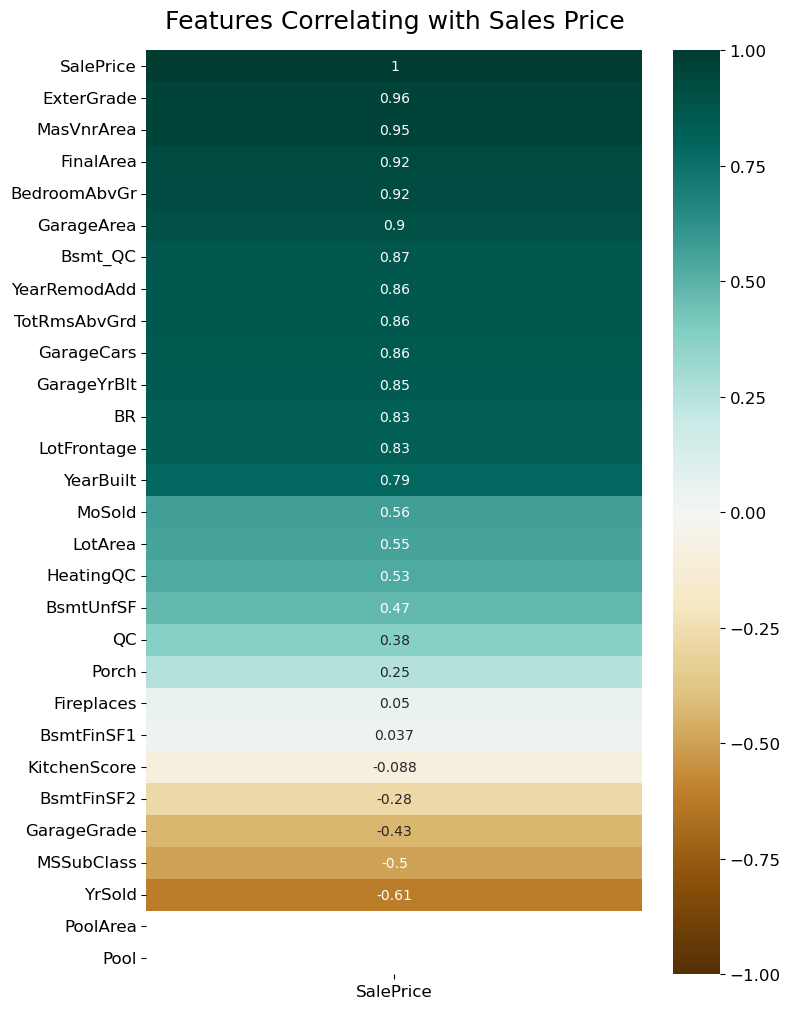

In [32]:
# Create correlation matrix from train data excluding `SalePrice`
corr_mat = train_clean.iloc[:22].corr()
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(corr_mat.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Sales Price', fontdict={'fontsize':18}, pad=16);

## Set ordinal encoder for train

Within the data cleaning section, we imputted select null values with 'None' and left other categorical values the same without encoding them with numerical inputs. For those left as categorical, we need to update them to some form of a numerical feature that the regression better understands the data. To do this, we will use an ordinal encoder. The encoder will review all categorical inputs and replace each with a certain numeric value. So for everytime it sees a repeated categorical input, it will replace it with the same numeric input. 

The issue with ordinal encoders become apparent when you shift to the test data. The encoder trains itself to input categorical features based on the training data, so any categorical input that is not seen in the training data will confuse the encoder when we need to repeat steps for the test data. For unknown values, we will use the input '999' which will help us in identifying those values which are new to the model (in the event we should treat them differently).

In [33]:
cat_col = ["MSZoning", "LotShape", "LandContour","LotConfig", 
           "LandSlope", "Neighborhood", "Condition1","BldgType", "HouseStyle", 
           "YearBuilt","YearRemodAdd", "RoofStyle", "Exterior1st", "Exterior2nd",
           "MasVnrType", "Foundation", "BsmtExposure", "BsmtFinType1",
           "BsmtFinType2","HeatingQC", "FireplaceQu", "GarageType", "GarageYrBlt",
           "GarageFinish","PoolQC","Fence","YrSold","SaleType","SaleCondition","Pool"]


In [34]:
#perform ordinal encoder on train cleaned data
ordinal_encoder1 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999)

ordinal_encoder1.fit(train_clean[cat_col])
train_clean[cat_col] = ordinal_encoder1.transform(train_clean[cat_col])

## Test-train split

Next we split up the training set into a smaller training and validation set to compare the performance of our trained models on the validation set. The split divides our data into the small training set (75%) and a validation set (25%) randomly. Additionally, the random state 201 is used for reproducibility with the function for comparative purposes. 

In [35]:
#determine split of data
df_smaller_train, df_validation = train_test_split(train_clean, test_size = 0.25, 
                                                   random_state = 201)


In [36]:
#create copy for train and validate
df_smaller_train = df_smaller_train.copy()
df_validation = df_validation.copy()

In [37]:
summarize_dataframe(df_smaller_train)

,Data Type,Missing Values,Unique Values,count,mean,std,min,25%,50%,75%,max
SalePrice,int64,0,558,1095.0,181968.404566,80177.160703,34900.000000,130000.000000,164500.000000,215000.000000,755000.000000
LotFrontage,float64,0,108,1095.0,-3.180050,0.046326,-3.282897,-3.202439,-3.181706,-3.163242,-2.680494
LotArea,float64,0,840,1095.0,-1.054017,0.000100,-1.054110,-1.054048,-1.054028,-1.054006,-1.051961
MasVnrArea,float64,0,270,1095.0,-0.574411,0.005441,-0.577593,-0.577593,-0.577593,-0.572406,-0.528487
BsmtFinSF1,float64,0,515,1095.0,-0.972979,0.002234,-0.975152,-0.975152,-0.973276,-0.971691,-0.948002
BsmtFinSF2,float64,0,114,1095.0,-0.288607,0.006226,-0.290443,-0.290443,-0.290443,-0.290443,-0.247107
BsmtUnfSF,float64,0,666,1095.0,-1.284196,0.002243,-1.287083,-1.285919,-1.284659,-1.282993,-1.275110
BedroomAbvGr,float64,0,7,1095.0,-3.531087,1.212387,-7.825139,-4.817792,-3.314119,-3.314119,1.196902
TotRmsAbvGrd,float64,0,11,1095.0,-4.005482,0.616327,-5.722593,-4.586269,-4.207495,-3.828720,-1.934848
Fireplaces,float64,0,4,1095.0,-0.942980,1.573014,-2.427265,-2.427265,-0.019426,-0.019426,4.796253


In [38]:
summarize_dataframe(df_validation)

,Data Type,Missing Values,Unique Values,count,mean,std,min,25%,50%,75%,max
SalePrice,int64,0,259,365.0,177779.569863,77219.244729,40000.000000,129000.000000,160000.000000,205000.000000,625000.000000
LotFrontage,float64,0,79,365.0,-3.186673,0.042329,-3.282897,-3.202439,-3.181706,-3.171494,-2.967254
LotArea,float64,0,310,365.0,-1.054020,0.000101,-1.054109,-1.054048,-1.054031,-1.054011,-1.052470
MasVnrArea,float64,0,123,365.0,-0.574408,0.005840,-0.577593,-0.577593,-0.577593,-0.573419,-0.535301
BsmtFinSF1,float64,0,219,365.0,-0.973135,0.002068,-0.975152,-0.975152,-0.973473,-0.971852,-0.964627
BsmtFinSF2,float64,0,39,365.0,-0.288790,0.006139,-0.290443,-0.290443,-0.290443,-0.290443,-0.233764
BsmtUnfSF,float64,0,281,365.0,-1.284114,0.002331,-1.287083,-1.286017,-1.284515,-1.282603,-1.276212
BedroomAbvGr,float64,0,7,365.0,-3.466546,1.269000,-6.321466,-4.817792,-3.314119,-3.314119,4.204249
TotRmsAbvGrd,float64,0,11,365.0,-4.029004,0.614150,-5.343818,-4.586269,-4.207495,-3.828720,-1.177300
Fireplaces,float64,0,4,365.0,-0.975965,1.490061,-2.427265,-2.427265,-0.019426,-0.019426,4.796253


## Tree train validation

We will also split for the tree given that we will manipulate the data differently dependent upon the models we choose to run.

In [39]:
#tree train
X_train_tree = df_smaller_train[df_smaller_train.columns[1:]].copy()
y_train_tree = df_smaller_train['SalePrice'].copy()

#tree validate
X_validation_tree = df_validation[df_smaller_train.columns[1:]].copy()
y_validation_tree = df_validation['SalePrice'].copy()

## Set Up Eval Metric

Prior to running the models, we will establish the evaluation metrics used to compare the models. For the Kaggle Ames competition, we will primarily focus on RMSLE as a means to determine the models effectiveness. Additionally, as we develop the various tree based models we will want to assess the importance each feature has on our results.

In [40]:
#RMSLE Function
def RMSLE(y_true, y_pred):
    y_pred_use = y_pred.clip(0)
    rmsle = mean_squared_log_error(y_true, y_pred_use)**(1/2)
    return rmsle

In [41]:
#Accuracy Function
def accuracy(y_true, y_pred):
    """Function that returns a table showing RMSE and MAE."""
    acc_df = pd.DataFrame(data = {"RMSE": [mean_squared_error(y_true, y_pred)**(1/2)],
                                  "MAE": [mean_absolute_error(y_true, y_pred)],
                                  "R^2": [r2_score(y_true, y_pred)],
                                  "RMSLE": [RMSLE(y_true, y_pred)]})
    display(acc_df.style.hide(axis='index'))

In [42]:
#Tree feature importance
def get_tree_importances(model, data):
    return pd.DataFrame({'Importance': model.feature_importances_}, index=data.columns).sort_values(['Importance'], ascending=False)

## X Y Prep - PCA

Due to the number of variables present, it will be interesting to see how a shortened, PCA version model compares against a non-PCA model. We will convert both the smaller train and smaller test to PCA. This will be done initially by identifying the number of components we wish to output in our PCA model followed by identifying those columns for PCA consolidation. For this model, we will consolidate columns 1-22.

In [43]:
#determine # of components to use
n_components = 5
pca = PCA(n_components = n_components)

In [45]:
#pull only those columns being compressed (i.e. not sale price or categorical features)
df_smaller_train.columns[1:22]

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageArea',
       'PoolArea', 'FinalArea', 'GarageCars', 'MoSold', 'GarageGrade',
       'KitchenScore', 'ExterGrade', 'QC', 'BR', 'Porch', 'Bsmt_QC'],
      dtype='object')

In [46]:
#fit pca on continuous features
pca.fit(df_smaller_train[df_smaller_train.columns[1:22]])

PCA(n_components=5)

In [47]:
#transform pca features
df_smaller_train_PCA = pca.transform(df_smaller_train[df_smaller_train.columns[1:22]])

In [48]:
#view pca training
df_smaller_train_PCA

array([[-1.83458474e+02, -6.30276132e+00, -4.83530869e-01,
        -5.03390494e+00,  9.57432237e-01],
       [ 1.51537581e+02, -1.10236676e+01, -2.14543759e+00,
         2.67357780e+00,  9.83119411e-01],
       [ 7.47776112e+01,  5.17027164e+00, -6.67409648e-01,
        -1.36612983e+00, -1.80916372e-02],
       ...,
       [ 8.05502293e+01, -6.70172272e+00,  8.79999864e+00,
        -1.50675217e+00,  4.39347634e+00],
       [-1.15458026e+02, -7.30623684e+00, -2.30000575e-01,
         9.04201342e-01,  1.26704203e+00],
       [-1.83448591e+02, -6.19337508e+00, -4.52108008e-01,
         9.84787920e-01,  1.26106780e+00]])

In [49]:
#shape dataframe
PCA_df_smaller_train = pd.DataFrame(df_smaller_train_PCA, columns=["PCA_" + str(i) for i in range(1,df_smaller_train_PCA.shape[1] + 1)], index = df_smaller_train.index)

In [50]:
df_smaller_train[df_smaller_train.columns[0]]

77      127000
628     135000
301     267000
1248    129500
880     157000
         ...  
983     255900
501     226700
868     169000
1377    117000
512     129900
Name: SalePrice, Length: 1095, dtype: int64

In [51]:
df_smaller_train[df_smaller_train.columns[23:]]

,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,PoolQC,Fence,YrSold,SaleType,SaleCondition,Pool
77,4.0,3.0,3.0,4.0,0.0,3.0,2.0,0.0,0.0,49.0,51.0,1.0,13.0,14.0,2.0,1.0,3.0,1.0,2.0,2.0,3.0,5.0,34.0,3.0,3.0,2.0,2.0,8.0,4.0,0.0
628,3.0,0.0,1.0,4.0,2.0,12.0,2.0,0.0,5.0,70.0,19.0,1.0,9.0,10.0,1.0,2.0,0.0,5.0,6.0,2.0,5.0,1.0,55.0,3.0,3.0,4.0,1.0,8.0,3.0,0.0
301,3.0,2.0,3.0,4.0,0.0,5.0,2.0,0.0,5.0,99.0,49.0,1.0,12.0,13.0,2.0,2.0,3.0,2.0,6.0,4.0,5.0,3.0,84.0,0.0,3.0,4.0,1.0,8.0,4.0,0.0
1248,4.0,3.0,3.0,4.0,0.0,17.0,2.0,0.0,4.0,21.0,0.0,1.0,0.0,0.0,2.0,0.0,3.0,5.0,6.0,1.0,2.0,5.0,36.0,3.0,3.0,4.0,2.0,8.0,4.0,0.0
880,3.0,3.0,3.0,4.0,0.0,7.0,2.0,0.0,2.0,106.0,56.0,1.0,12.0,13.0,2.0,2.0,3.0,0.0,6.0,3.0,3.0,1.0,91.0,0.0,3.0,4.0,1.0,8.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,3.0,3.0,3.0,0.0,0.0,5.0,2.0,0.0,5.0,103.0,52.0,1.0,5.0,5.0,2.0,2.0,2.0,6.0,6.0,4.0,2.0,1.0,88.0,3.0,3.0,4.0,2.0,8.0,4.0,0.0
501,1.0,3.0,3.0,4.0,0.0,21.0,2.0,0.0,5.0,106.0,55.0,1.0,12.0,13.0,2.0,2.0,3.0,2.0,6.0,3.0,3.0,1.0,91.0,2.0,3.0,4.0,2.0,8.0,4.0,0.0
868,3.0,1.0,3.0,0.0,0.0,8.0,1.0,0.0,5.0,49.0,0.0,1.0,9.0,10.0,2.0,3.0,4.0,4.0,4.0,3.0,5.0,1.0,65.0,3.0,3.0,4.0,0.0,8.0,4.0,0.0
1377,3.0,3.0,3.0,4.0,0.0,7.0,2.0,0.0,0.0,44.0,10.0,1.0,13.0,14.0,2.0,1.0,3.0,3.0,1.0,4.0,3.0,5.0,63.0,3.0,3.0,4.0,3.0,8.0,4.0,0.0


In [52]:
#concatenate pca with salesprice and categorical features
df_smaller_train_with_PCA = pd.concat([df_smaller_train[df_smaller_train.columns[0]], df_smaller_train[df_smaller_train.columns[23:]], PCA_df_smaller_train], axis=1)

In [53]:
#view dataset
df_smaller_train_with_PCA

,SalePrice,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,PoolQC,Fence,YrSold,SaleType,SaleCondition,Pool,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
77,127000,4.0,3.0,3.0,4.0,0.0,3.0,2.0,0.0,0.0,49.0,51.0,1.0,13.0,14.0,2.0,1.0,3.0,1.0,2.0,2.0,3.0,5.0,34.0,3.0,3.0,2.0,2.0,8.0,4.0,0.0,-183.458474,-6.302761,-0.483531,-5.033905,0.957432
628,135000,3.0,0.0,1.0,4.0,2.0,12.0,2.0,0.0,5.0,70.0,19.0,1.0,9.0,10.0,1.0,2.0,0.0,5.0,6.0,2.0,5.0,1.0,55.0,3.0,3.0,4.0,1.0,8.0,3.0,0.0,151.537581,-11.023668,-2.145438,2.673578,0.983119
301,267000,3.0,2.0,3.0,4.0,0.0,5.0,2.0,0.0,5.0,99.0,49.0,1.0,12.0,13.0,2.0,2.0,3.0,2.0,6.0,4.0,5.0,3.0,84.0,0.0,3.0,4.0,1.0,8.0,4.0,0.0,74.777611,5.170272,-0.667410,-1.366130,-0.018092
1248,129500,4.0,3.0,3.0,4.0,0.0,17.0,2.0,0.0,4.0,21.0,0.0,1.0,0.0,0.0,2.0,0.0,3.0,5.0,6.0,1.0,2.0,5.0,36.0,3.0,3.0,4.0,2.0,8.0,4.0,0.0,75.599956,-5.442336,0.077749,-2.219487,-4.252823
880,157000,3.0,3.0,3.0,4.0,0.0,7.0,2.0,0.0,2.0,106.0,56.0,1.0,12.0,13.0,2.0,2.0,3.0,0.0,6.0,3.0,3.0,1.0,91.0,0.0,3.0,4.0,1.0,8.0,4.0,0.0,-134.404388,-5.635000,-9.863658,0.017429,-2.470054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,255900,3.0,3.0,3.0,0.0,0.0,5.0,2.0,0.0,5.0,103.0,52.0,1.0,5.0,5.0,2.0,2.0,2.0,6.0,6.0,4.0,2.0,1.0,88.0,3.0,3.0,4.0,2.0,8.0,4.0,0.0,-183.185104,9.419650,-1.537641,-1.051133,-0.039151
501,226700,1.0,3.0,3.0,4.0,0.0,21.0,2.0,0.0,5.0,106.0,55.0,1.0,12.0,13.0,2.0,2.0,3.0,2.0,6.0,3.0,3.0,1.0,91.0,2.0,3.0,4.0,2.0,8.0,4.0,0.0,-75.290395,2.562660,-1.991501,-4.145301,-0.306997
868,169000,3.0,1.0,3.0,0.0,0.0,8.0,1.0,0.0,5.0,49.0,0.0,1.0,9.0,10.0,2.0,3.0,4.0,4.0,4.0,3.0,5.0,1.0,65.0,3.0,3.0,4.0,0.0,8.0,4.0,0.0,80.550229,-6.701723,8.799999,-1.506752,4.393476
1377,117000,3.0,3.0,3.0,4.0,0.0,7.0,2.0,0.0,0.0,44.0,10.0,1.0,13.0,14.0,2.0,1.0,3.0,3.0,1.0,4.0,3.0,5.0,63.0,3.0,3.0,4.0,3.0,8.0,4.0,0.0,-115.458026,-7.306237,-0.230001,0.904201,1.267042


In [54]:
summarize_dataframe(df_smaller_train_with_PCA)

,Data Type,Missing Values,Unique Values,count,mean,std,min,25%,50%,75%,max
SalePrice,int64,0,558,1095.0,1.819684e+05,80177.160703,34900.000000,130000.000000,164500.000000,215000.000000,755000.000000
MSZoning,float64,0,5,1095.0,3.021005e+00,0.633118,0.000000,3.000000,3.000000,3.000000,4.000000
LotShape,float64,0,4,1095.0,1.926027e+00,1.410657,0.000000,0.000000,3.000000,3.000000,3.000000
LandContour,float64,0,4,1095.0,2.771689e+00,0.712209,0.000000,3.000000,3.000000,3.000000,3.000000
LotConfig,float64,0,5,1095.0,3.022831e+00,1.626008,0.000000,2.000000,4.000000,4.000000,4.000000
LandSlope,float64,0,3,1095.0,6.849315e-02,0.292913,0.000000,0.000000,0.000000,0.000000,2.000000
Neighborhood,float64,0,25,1095.0,1.231233e+01,6.048341,0.000000,7.000000,12.000000,17.000000,24.000000
Condition1,float64,0,9,1095.0,2.037443e+00,0.900673,0.000000,2.000000,2.000000,2.000000,8.000000
BldgType,float64,0,5,1095.0,4.557078e-01,1.155862,0.000000,0.000000,0.000000,0.000000,4.000000
HouseStyle,float64,0,8,1095.0,3.066667e+00,1.923618,0.000000,2.000000,2.000000,5.000000,7.000000


Now that the smaller train dataset has been transformed with PCA, we will follow the exact same process with the smaller validation dataset. 

In [55]:
# Reform with validation smaller data set

In [56]:
#view smaller train file
df_validation.head()

,SalePrice,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,PoolArea,FinalArea,GarageCars,MoSold,GarageGrade,KitchenScore,ExterGrade,QC,BR,Porch,Bsmt_QC,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,PoolQC,Fence,YrSold,SaleType,SaleCondition,Pool
826,109500,-3.223069,-1.054062,-0.577593,-0.971381,-0.290443,-1.287083,-4.817792,-4.586269,-2.427265,-2.223317,-0.070402,-3.127312,0,5,0,4,9,30,2.0,116,9,45,4.0,3.0,3.0,4.0,0.0,3.0,2.0,0.0,1.0,28.0,0.0,1.0,8.0,8.0,2.0,0.0,3.0,0.0,6.0,3.0,3.0,6.0,64.0,1.0,3.0,4.0,2.0,8.0,4.0,0.0
17,90000,-3.177683,-1.054015,-0.577593,-0.975152,-0.290443,-1.287083,-4.817792,-4.207495,-2.427265,-2.212021,-0.070402,-3.127172,2,10,9,6,9,20,2.0,0,0,90,3.0,3.0,3.0,4.0,0.0,19.0,2.0,2.0,2.0,68.0,17.0,1.0,8.0,8.0,2.0,3.0,4.0,4.0,4.0,2.0,3.0,4.0,53.0,3.0,3.0,4.0,0.0,8.0,4.0,0.0
649,84500,-3.282897,-1.054104,-0.577593,-0.974522,-0.271255,-1.287083,-6.321466,-5.343818,-2.427265,-2.223317,-0.070402,-3.127583,0,12,0,3,9,24,2.0,0,12,180,4.0,3.0,3.0,4.0,0.0,10.0,2.0,3.0,6.0,71.0,20.0,1.0,5.0,5.0,2.0,1.0,0.0,1.0,2.0,3.0,3.0,6.0,64.0,1.0,3.0,2.0,1.0,8.0,4.0,0.0
585,369900,-3.144674,-1.054009,-0.571209,-0.968129,-0.290443,-1.284992,-4.817792,-3.828720,2.388414,-2.204053,-0.070402,-3.125218,3,3,9,4,12,40,3.0,392,15,20,3.0,3.0,3.0,4.0,0.0,23.0,2.0,0.0,2.0,106.0,56.0,3.0,12.0,13.0,1.0,2.0,1.0,2.0,6.0,4.0,2.0,1.0,91.0,2.0,3.0,4.0,0.0,6.0,5.0,0.0
138,230000,-3.175620,-1.054032,-0.567772,-0.971939,-0.290443,-1.285361,-3.314119,-3.828720,2.388414,-2.208869,-0.070402,-3.125931,3,12,9,4,12,40,2.5,330,12,60,3.0,0.0,3.0,4.0,0.0,5.0,2.0,0.0,5.0,100.0,50.0,1.0,12.0,13.0,1.0,2.0,2.0,2.0,6.0,4.0,5.0,1.0,85.0,0.0,3.0,0.0,2.0,8.0,4.0,0.0


In [57]:
#pull only those columns being compressed (i.e. not sale price or categorical features)
df_validation.columns[1:22]

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageArea',
       'PoolArea', 'FinalArea', 'GarageCars', 'MoSold', 'GarageGrade',
       'KitchenScore', 'ExterGrade', 'QC', 'BR', 'Porch', 'Bsmt_QC'],
      dtype='object')

In [58]:
#fit pca on continuous features
pca.fit(df_validation[df_validation.columns[1:22]])

PCA(n_components=5)

In [59]:
#transform pca features
df_validation_PCA = pca.transform(df_validation[df_validation.columns[1:22]])

In [60]:
#view pca training
df_validation_PCA

array([[-5.94422876e+01, -3.20325315e+00,  3.58394896e+00,
         6.39844659e-01, -7.65450830e+00],
       [-1.75612542e+02, -1.12109967e+01,  5.60119845e+00,
        -5.97807563e+00,  3.85613256e+00],
       [-1.75520677e+02, -6.50126823e+00, -2.57437782e+00,
        -4.55795851e+00, -8.46278129e+00],
       ...,
       [ 1.01198910e+02, -2.44526094e+01,  7.56619014e+00,
        -8.83071706e-01,  3.79688222e+00],
       [ 1.66902760e+01,  2.16556938e+00, -7.89665870e-01,
         8.48371235e-01,  8.19977664e-02],
       [-1.31290979e+02,  4.20691450e+00, -1.44256888e+00,
         2.25001591e+00,  3.06384844e-01]])

In [61]:
#shape dataframe
PCA_df_validation = pd.DataFrame(df_validation_PCA, columns=["PCA_" + str(i) for i in range(1,df_validation_PCA.shape[1] + 1)], index = df_validation.index)

In [62]:
df_validation[df_validation.columns[0]]

826    109500
17      90000
649     84500
585    369900
138    230000
        ...  
728    110000
166    190000
749     98000
360    156000
959    155000
Name: SalePrice, Length: 365, dtype: int64

In [63]:
df_validation[df_validation.columns[23:]]

,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,PoolQC,Fence,YrSold,SaleType,SaleCondition,Pool
826,4.0,3.0,3.0,4.0,0.0,3.0,2.0,0.0,1.0,28.0,0.0,1.0,8.0,8.0,2.0,0.0,3.0,0.0,6.0,3.0,3.0,6.0,64.0,1.0,3.0,4.0,2.0,8.0,4.0,0.0
17,3.0,3.0,3.0,4.0,0.0,19.0,2.0,2.0,2.0,68.0,17.0,1.0,8.0,8.0,2.0,3.0,4.0,4.0,4.0,2.0,3.0,4.0,53.0,3.0,3.0,4.0,0.0,8.0,4.0,0.0
649,4.0,3.0,3.0,4.0,0.0,10.0,2.0,3.0,6.0,71.0,20.0,1.0,5.0,5.0,2.0,1.0,0.0,1.0,2.0,3.0,3.0,6.0,64.0,1.0,3.0,2.0,1.0,8.0,4.0,0.0
585,3.0,3.0,3.0,4.0,0.0,23.0,2.0,0.0,2.0,106.0,56.0,3.0,12.0,13.0,1.0,2.0,1.0,2.0,6.0,4.0,2.0,1.0,91.0,2.0,3.0,4.0,0.0,6.0,5.0,0.0
138,3.0,0.0,3.0,4.0,0.0,5.0,2.0,0.0,5.0,100.0,50.0,1.0,12.0,13.0,1.0,2.0,2.0,2.0,6.0,4.0,5.0,1.0,85.0,0.0,3.0,0.0,2.0,8.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,3.0,3.0,3.0,0.0,0.0,12.0,2.0,2.0,2.0,59.0,8.0,1.0,12.0,13.0,1.0,1.0,3.0,6.0,6.0,2.0,3.0,5.0,54.0,3.0,3.0,4.0,3.0,0.0,0.0,0.0
166,3.0,0.0,3.0,4.0,0.0,4.0,2.0,0.0,2.0,56.0,43.0,3.0,13.0,14.0,2.0,1.0,3.0,3.0,1.0,4.0,2.0,1.0,41.0,0.0,3.0,1.0,3.0,0.0,4.0,0.0
749,3.0,3.0,3.0,4.0,0.0,7.0,2.0,0.0,0.0,46.0,0.0,1.0,14.0,15.0,2.0,3.0,4.0,4.0,4.0,2.0,3.0,5.0,31.0,3.0,3.0,4.0,3.0,8.0,4.0,0.0
360,3.0,0.0,3.0,1.0,0.0,11.0,2.0,0.0,6.0,79.0,28.0,1.0,12.0,13.0,2.0,1.0,0.0,2.0,6.0,4.0,5.0,1.0,64.0,2.0,3.0,2.0,1.0,8.0,4.0,0.0


In [64]:
#concatenate pca with salesprice and categorical features
df_validation_with_PCA = pd.concat([df_validation[df_validation.columns[0]], df_validation[df_validation.columns[23:]], PCA_df_validation], axis=1)

In [65]:
#view dataset
df_validation_with_PCA

,SalePrice,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,PoolQC,Fence,YrSold,SaleType,SaleCondition,Pool,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
826,109500,4.0,3.0,3.0,4.0,0.0,3.0,2.0,0.0,1.0,28.0,0.0,1.0,8.0,8.0,2.0,0.0,3.0,0.0,6.0,3.0,3.0,6.0,64.0,1.0,3.0,4.0,2.0,8.0,4.0,0.0,-59.442288,-3.203253,3.583949,0.639845,-7.654508
17,90000,3.0,3.0,3.0,4.0,0.0,19.0,2.0,2.0,2.0,68.0,17.0,1.0,8.0,8.0,2.0,3.0,4.0,4.0,4.0,2.0,3.0,4.0,53.0,3.0,3.0,4.0,0.0,8.0,4.0,0.0,-175.612542,-11.210997,5.601198,-5.978076,3.856133
649,84500,4.0,3.0,3.0,4.0,0.0,10.0,2.0,3.0,6.0,71.0,20.0,1.0,5.0,5.0,2.0,1.0,0.0,1.0,2.0,3.0,3.0,6.0,64.0,1.0,3.0,2.0,1.0,8.0,4.0,0.0,-175.520677,-6.501268,-2.574378,-4.557959,-8.462781
585,369900,3.0,3.0,3.0,4.0,0.0,23.0,2.0,0.0,2.0,106.0,56.0,3.0,12.0,13.0,1.0,2.0,1.0,2.0,6.0,4.0,2.0,1.0,91.0,2.0,3.0,4.0,0.0,6.0,5.0,0.0,216.762444,3.140101,-2.283357,4.384030,-0.573023
138,230000,3.0,0.0,3.0,4.0,0.0,5.0,2.0,0.0,5.0,100.0,50.0,1.0,12.0,13.0,1.0,2.0,2.0,2.0,6.0,4.0,5.0,1.0,85.0,0.0,3.0,0.0,2.0,8.0,4.0,0.0,154.757320,4.174424,-2.652086,-5.050837,-0.002975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,110000,3.0,3.0,3.0,0.0,0.0,12.0,2.0,2.0,2.0,59.0,8.0,1.0,12.0,13.0,1.0,1.0,3.0,6.0,6.0,2.0,3.0,5.0,54.0,3.0,3.0,4.0,3.0,0.0,0.0,0.0,-150.486763,-5.842099,-0.306456,-0.637695,1.262833
166,190000,3.0,0.0,3.0,4.0,0.0,4.0,2.0,0.0,2.0,56.0,43.0,3.0,13.0,14.0,2.0,1.0,3.0,3.0,1.0,4.0,2.0,1.0,41.0,0.0,3.0,1.0,3.0,0.0,4.0,0.0,442.432511,-16.257043,-1.171978,-5.241883,0.910260
749,98000,3.0,3.0,3.0,4.0,0.0,7.0,2.0,0.0,0.0,46.0,0.0,1.0,14.0,15.0,2.0,3.0,4.0,4.0,4.0,2.0,3.0,5.0,31.0,3.0,3.0,4.0,3.0,8.0,4.0,0.0,101.198910,-24.452609,7.566190,-0.883072,3.796882
360,156000,3.0,0.0,3.0,1.0,0.0,11.0,2.0,0.0,6.0,79.0,28.0,1.0,12.0,13.0,2.0,1.0,0.0,2.0,6.0,4.0,5.0,1.0,64.0,2.0,3.0,2.0,1.0,8.0,4.0,0.0,16.690276,2.165569,-0.789666,0.848371,0.081998


In [66]:
summarize_dataframe(df_validation_with_PCA)

,Data Type,Missing Values,Unique Values,count,mean,std,min,25%,50%,75%,max
SalePrice,int64,0,259,365.0,1.777796e+05,77219.244729,40000.000000,129000.000000,160000.000000,205000.000000,625000.000000
MSZoning,float64,0,5,365.0,3.052055e+00,0.628995,0.000000,3.000000,3.000000,3.000000,4.000000
LotShape,float64,0,4,365.0,1.991781e+00,1.405421,0.000000,0.000000,3.000000,3.000000,3.000000
LandContour,float64,0,4,365.0,2.794521e+00,0.694541,0.000000,3.000000,3.000000,3.000000,3.000000
LotConfig,float64,0,4,365.0,3.008219e+00,1.614644,0.000000,2.000000,4.000000,4.000000,4.000000
LandSlope,float64,0,3,365.0,4.383562e-02,0.217999,0.000000,0.000000,0.000000,0.000000,2.000000
Neighborhood,float64,0,24,365.0,1.206849e+01,5.913127,0.000000,7.000000,12.000000,17.000000,24.000000
Condition1,float64,0,7,365.0,2.013699e+00,0.764838,0.000000,2.000000,2.000000,2.000000,6.000000
BldgType,float64,0,5,365.0,6.054795e-01,1.312649,0.000000,0.000000,0.000000,0.000000,4.000000
HouseStyle,float64,0,8,365.0,2.953425e+00,1.873916,0.000000,2.000000,2.000000,5.000000,7.000000


## X Y Prep

### Prep Non PCA Data

We do not only want to run our models using an abbreivated PCA dataset. We also want to prepare data for our other to-be models that require a matrix format.

In [67]:
X_train = df_smaller_train[df_smaller_train.columns[1:]].copy()
y_train = df_smaller_train['SalePrice'].copy()

In [68]:
X_validation = df_validation[df_validation.columns[1:]].copy()
y_validation = df_validation['SalePrice'].copy()

In [69]:
#formula = 'SalePrice ~ ' + 'Q("' + '") + 0 + Q("'.join(df_smaller_train.columns[1:]) + '")'
formula = 'SalePrice ~ ' + 'Q("' + '") + 0 + Q("'.join(df_smaller_train.columns[1:]) + '")'

#adding 0 to remove intercept

In [70]:
y_train, X_train = dmatrices(formula, df_smaller_train, return_type="dataframe")

In [71]:
#replace leading Q in column name
X_train.columns = X_train.columns.str[1:]

#replace special characters in column name
X_train.columns = X_train.columns.str.replace('[",(,)]', '')

C:\Users\brwil\AppData\Local\Temp\ipykernel_26420\182290722.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  X_train.columns = X_train.columns.str.replace('[",(,)]', '')


In [72]:
X_train.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,PoolArea,FinalArea,GarageCars,MoSold,GarageGrade,KitchenScore,ExterGrade,QC,BR,Porch,Bsmt_QC,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,PoolQC,Fence,YrSold,SaleType,SaleCondition,Pool
77,-3.223069,-1.054037,-0.577593,-0.973536,-0.288866,-1.285571,-4.817792,-4.207495,-2.427265,-2.218063,-0.070402,-3.126791,1.0,1.0,9.0,3.0,9.0,25.0,2.0,0.0,9.0,50.0,4.0,3.0,3.0,4.0,0.0,3.0,2.0,0.0,0.0,49.0,51.0,1.0,13.0,14.0,2.0,1.0,3.0,1.0,2.0,2.0,3.0,5.0,34.0,3.0,3.0,2.0,2.0,8.0,4.0,0.0
628,-3.181809,-1.054007,-0.571700,-0.972026,-0.290443,-1.285084,-0.306772,-3.071172,2.388414,-2.212284,-0.070402,-3.125642,2.0,9.0,9.0,2.0,9.0,25.0,2.5,335.0,12.0,60.0,3.0,0.0,1.0,4.0,2.0,12.0,2.0,0.0,5.0,70.0,19.0,1.0,9.0,10.0,1.0,2.0,0.0,5.0,6.0,2.0,5.0,1.0,55.0,3.0,3.0,4.0,1.0,8.0,3.0,0.0
301,-3.190061,-1.053961,-0.577593,-0.973801,-0.290443,-1.283254,-1.810445,-3.071172,-0.019426,-2.208365,-0.070402,-3.125213,2.0,5.0,9.0,4.0,12.0,40.0,2.5,258.0,12.0,60.0,3.0,2.0,3.0,4.0,0.0,5.0,2.0,0.0,5.0,99.0,49.0,1.0,12.0,13.0,2.0,2.0,3.0,2.0,6.0,4.0,5.0,3.0,84.0,0.0,3.0,4.0,1.0,8.0,4.0,0.0
1248,-3.202439,-1.054027,-0.577593,-0.973618,-0.290443,-1.284951,-3.314119,-3.449946,-0.019426,-2.214648,-0.070402,-3.125847,2.0,4.0,4.0,3.0,9.0,30.0,1.5,259.0,12.0,75.0,4.0,3.0,3.0,4.0,0.0,17.0,2.0,0.0,4.0,21.0,0.0,1.0,0.0,0.0,2.0,0.0,3.0,5.0,6.0,1.0,2.0,5.0,36.0,3.0,3.0,4.0,2.0,8.0,4.0,0.0
880,-3.202439,-1.054053,-0.577593,-0.970438,-0.290443,-1.286519,-4.817792,-4.586269,-2.427265,-2.213466,-0.070402,-3.126774,2.0,6.0,9.0,3.0,9.0,25.0,2.5,49.0,20.0,20.0,3.0,3.0,3.0,4.0,0.0,7.0,2.0,0.0,2.0,106.0,56.0,1.0,12.0,13.0,2.0,2.0,3.0,0.0,6.0,3.0,3.0,1.0,91.0,0.0,3.0,4.0,1.0,8.0,4.0,0.0


### Set PCA ordinal encoder for categorical values

Similar to our prior encoding process, the utilize the ordinal encoder on the PCA based data prior to using it with our models.

In [73]:
#build x and y features for tree
X_train_tree_PCA = df_smaller_train_with_PCA[df_smaller_train_with_PCA.columns[1:]].copy()
y_train_tree_PCA = df_smaller_train_with_PCA['SalePrice'].copy()

In [74]:
#prepare validation to test
X_validation_tree_PCA = df_validation_with_PCA[df_smaller_train_with_PCA.columns[1:]].copy()
y_validation_tree_PCA = df_validation_with_PCA['SalePrice'].copy()

In [75]:
X_train_tree_PCA.head()

,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,PoolQC,Fence,YrSold,SaleType,SaleCondition,Pool,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
77,4.0,3.0,3.0,4.0,0.0,3.0,2.0,0.0,0.0,49.0,51.0,1.0,13.0,14.0,2.0,1.0,3.0,1.0,2.0,2.0,3.0,5.0,34.0,3.0,3.0,2.0,2.0,8.0,4.0,0.0,-183.458474,-6.302761,-0.483531,-5.033905,0.957432
628,3.0,0.0,1.0,4.0,2.0,12.0,2.0,0.0,5.0,70.0,19.0,1.0,9.0,10.0,1.0,2.0,0.0,5.0,6.0,2.0,5.0,1.0,55.0,3.0,3.0,4.0,1.0,8.0,3.0,0.0,151.537581,-11.023668,-2.145438,2.673578,0.983119
301,3.0,2.0,3.0,4.0,0.0,5.0,2.0,0.0,5.0,99.0,49.0,1.0,12.0,13.0,2.0,2.0,3.0,2.0,6.0,4.0,5.0,3.0,84.0,0.0,3.0,4.0,1.0,8.0,4.0,0.0,74.777611,5.170272,-0.667410,-1.366130,-0.018092
1248,4.0,3.0,3.0,4.0,0.0,17.0,2.0,0.0,4.0,21.0,0.0,1.0,0.0,0.0,2.0,0.0,3.0,5.0,6.0,1.0,2.0,5.0,36.0,3.0,3.0,4.0,2.0,8.0,4.0,0.0,75.599956,-5.442336,0.077749,-2.219487,-4.252823
880,3.0,3.0,3.0,4.0,0.0,7.0,2.0,0.0,2.0,106.0,56.0,1.0,12.0,13.0,2.0,2.0,3.0,0.0,6.0,3.0,3.0,1.0,91.0,0.0,3.0,4.0,1.0,8.0,4.0,0.0,-134.404388,-5.635000,-9.863658,0.017429,-2.470054


In [76]:
#ordinal encoder
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [77]:
cat_col = ["MSZoning", "LotShape", "LandContour","LotConfig", 
           "LandSlope", "Neighborhood", "Condition1","BldgType", "HouseStyle", 
           "YearBuilt","YearRemodAdd", "RoofStyle", "Exterior1st", "Exterior2nd",
           "MasVnrType", "Foundation", "BsmtExposure", "BsmtFinType1",
           "BsmtFinType2","HeatingQC", "FireplaceQu", "GarageType", "GarageYrBlt",
           "GarageFinish","PoolQC","Fence","YrSold","SaleType","SaleCondition","Pool"]


ordinal_encoder.fit(X_train_tree_PCA[cat_col])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [78]:
#fit model
ordinal_encoder.fit(X_train_tree_PCA[cat_col])
X_train_tree_PCA[cat_col] = ordinal_encoder.transform(X_train_tree_PCA[cat_col])

In [79]:
X_validation_tree_PCA[cat_col] = ordinal_encoder.transform(X_validation_tree_PCA[cat_col])

In [80]:
X_validation_tree_PCA.head()

,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,PoolQC,Fence,YrSold,SaleType,SaleCondition,Pool,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
826,4.0,3.0,3.0,4.0,0.0,3.0,2.0,0.0,1.0,26.0,0.0,1.0,8.0,8.0,2.0,0.0,3.0,0.0,6.0,3.0,3.0,6.0,63.0,1.0,3.0,4.0,2.0,8.0,4.0,0.0,-59.442288,-3.203253,3.583949,0.639845,-7.654508
17,3.0,3.0,3.0,4.0,0.0,19.0,2.0,2.0,2.0,66.0,17.0,1.0,8.0,8.0,2.0,3.0,4.0,4.0,4.0,2.0,3.0,4.0,52.0,3.0,3.0,4.0,0.0,8.0,4.0,0.0,-175.612542,-11.210997,5.601198,-5.978076,3.856133
649,4.0,3.0,3.0,4.0,0.0,10.0,2.0,3.0,6.0,69.0,20.0,1.0,5.0,5.0,2.0,1.0,0.0,1.0,2.0,3.0,3.0,6.0,63.0,1.0,3.0,2.0,1.0,8.0,4.0,0.0,-175.520677,-6.501268,-2.574378,-4.557959,-8.462781
585,3.0,3.0,3.0,4.0,0.0,23.0,2.0,0.0,2.0,104.0,56.0,3.0,12.0,13.0,1.0,2.0,1.0,2.0,6.0,4.0,2.0,1.0,90.0,2.0,3.0,4.0,0.0,6.0,5.0,0.0,216.762444,3.140101,-2.283357,4.384030,-0.573023
138,3.0,0.0,3.0,4.0,0.0,5.0,2.0,0.0,5.0,98.0,50.0,1.0,12.0,13.0,1.0,2.0,2.0,2.0,6.0,4.0,5.0,1.0,84.0,0.0,3.0,0.0,2.0,8.0,4.0,0.0,154.757320,4.174424,-2.652086,-5.050837,-0.002975


In [81]:
X_train_tree_PCA.head()

,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,PoolQC,Fence,YrSold,SaleType,SaleCondition,Pool,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
77,4.0,3.0,3.0,4.0,0.0,3.0,2.0,0.0,0.0,47.0,51.0,1.0,13.0,14.0,2.0,1.0,3.0,1.0,2.0,2.0,3.0,5.0,33.0,3.0,3.0,2.0,2.0,8.0,4.0,0.0,-183.458474,-6.302761,-0.483531,-5.033905,0.957432
628,3.0,0.0,1.0,4.0,2.0,12.0,2.0,0.0,5.0,68.0,19.0,1.0,9.0,10.0,1.0,2.0,0.0,5.0,6.0,2.0,5.0,1.0,54.0,3.0,3.0,4.0,1.0,8.0,3.0,0.0,151.537581,-11.023668,-2.145438,2.673578,0.983119
301,3.0,2.0,3.0,4.0,0.0,5.0,2.0,0.0,5.0,97.0,49.0,1.0,12.0,13.0,2.0,2.0,3.0,2.0,6.0,4.0,5.0,3.0,83.0,0.0,3.0,4.0,1.0,8.0,4.0,0.0,74.777611,5.170272,-0.667410,-1.366130,-0.018092
1248,4.0,3.0,3.0,4.0,0.0,17.0,2.0,0.0,4.0,19.0,0.0,1.0,0.0,0.0,2.0,0.0,3.0,5.0,6.0,1.0,2.0,5.0,35.0,3.0,3.0,4.0,2.0,8.0,4.0,0.0,75.599956,-5.442336,0.077749,-2.219487,-4.252823
880,3.0,3.0,3.0,4.0,0.0,7.0,2.0,0.0,2.0,104.0,56.0,1.0,12.0,13.0,2.0,2.0,3.0,0.0,6.0,3.0,3.0,1.0,90.0,0.0,3.0,4.0,1.0,8.0,4.0,0.0,-134.404388,-5.635000,-9.863658,0.017429,-2.470054


## Models

Now we will run multiple different models. We want to see if there are certain models which run better than others and we would like to ensemble the models for our final test data. This will hopefully allow us to assess the effectiveness of various models and avoid overfitting by choosing multiple models. To do so, we will run a random forest with PCA to determine if we wish to move forward with our PCA data. Additionally we will run a decision tree, neural network, XGBoost, Light GBM, and finally a linear regression to ensemble the models together.

### Random Forest with PCA

To determine the effectiveness of our PCA data, we will initially run a random forest using the data. This may not be nearly as effective given PCAs greater effectiveness with linear based models. 

In [82]:
#fit model
rf = RandomForestRegressor(n_estimators=700,
                           max_features=10,
                           min_samples_leaf=5,
                           random_state=201,
                           ccp_alpha=0,
                           n_jobs=num_cpus,
                          bootstrap = True,
                          oob_score = True)
rf_model = rf.fit(X_train_tree_PCA, y_train_tree_PCA)
rf_pred = rf_model.predict(X_validation_tree_PCA)

In [83]:
rf_model.fit(X_train_tree_PCA, y_train_tree_PCA)

RandomForestRegressor(ccp_alpha=0, max_features=10, min_samples_leaf=5,
                      n_estimators=700, n_jobs=12, oob_score=True,
                      random_state=201)

In [84]:
#feature importance
pd.DataFrame({'Importance': rf_model.feature_importances_}, index=X_train_tree_PCA.columns).sort_values(['Importance'], ascending=False)

,Importance
YearBuilt,0.170779
PCA_2,0.146357
GarageYrBlt,0.103208
PCA_1,0.074838
PCA_5,0.069222
YearRemodAdd,0.061202
GarageType,0.061153
FireplaceQu,0.055350
Foundation,0.039776
Neighborhood,0.035684


In [85]:
rf_pred = rf_model.predict(X_validation_tree_PCA)

In [86]:
accuracy(y_validation_tree_PCA, rf_pred)

RMSE,MAE,R^2,RMSLE
39584.408557,26676.952474,0.736495,0.194617


Our performance is good, but it will be worth comparing against the random forest without PCA to determine how we wish to move forward.

### Random Forest without PCA

Now we will run a similar random forest but using the full dataset. Typically trees will run better without PCA and using more data that it can split on.

In [92]:
#fit model
rf_model_nopca = RandomForestRegressor(n_estimators=700,
                           max_features=10,
                           min_samples_leaf=5,
                           random_state=201,
                           ccp_alpha=0,
                           n_jobs=num_cpus,
                          bootstrap = True,
                          oob_score = True)


In [93]:
rf_model_nopca.fit(X_train_tree, y_train_tree)


RandomForestRegressor(ccp_alpha=0, max_features=10, min_samples_leaf=5,
                      n_estimators=700, n_jobs=12, oob_score=True,
                      random_state=201)

In [94]:
rf_pred_noPCA = rf_model_nopca.predict(X_validation_tree)

In [95]:
pd.DataFrame({'Importance': rf_model_nopca.feature_importances_}, index=X_train_tree.columns).sort_values(['Importance'], ascending=False)

,Importance
FinalArea,0.232576
GarageCars,0.098558
YearBuilt,0.082870
GarageArea,0.075463
Bsmt_QC,0.061918
QC,0.056948
BR,0.054116
GarageYrBlt,0.037798
BsmtFinSF1,0.034928
KitchenScore,0.030036


In [96]:
accuracy(y_validation_tree, rf_pred_noPCA)

RMSE,MAE,R^2,RMSLE
26713.820952,16412.291691,0.879991,0.138071


We see divergence in both the importance of certain features and the accuracy of our model. It does appear that the non-PCA data operates with better performance using the tree datasets than the PCA data. For the remainder of the models we will use the non-PCA data to train and test.

### Decision Tree

In [87]:
dt_model = DecisionTreeRegressor(criterion = 'squared_error',
                                max_depth=20,
                                  ccp_alpha=0,
                                  min_samples_split=20, 
                                  max_features=.5,
                                  min_impurity_decrease=.001, 
                                  random_state=201)

In [88]:
dt_model.fit(X_train_tree, y_train_tree)

DecisionTreeRegressor(ccp_alpha=0, max_depth=20, max_features=0.5,
                      min_impurity_decrease=0.001, min_samples_split=20,
                      random_state=201)

In [89]:
dt_pred = dt_model.predict(X_validation_tree)

In [90]:
pd.DataFrame({'Importance': dt_model.feature_importances_}, index=X_train_tree.columns).sort_values(['Importance'], ascending=False)

,Importance
FinalArea,0.683927
GarageCars,0.110021
QC,0.039619
Bsmt_QC,0.031386
YearBuilt,0.025551
KitchenScore,0.017146
BsmtFinSF1,0.015766
GarageFinish,0.009649
GarageType,0.008829
Porch,0.008016


In [91]:
accuracy(y_validation_tree, dt_pred)

RMSE,MAE,R^2,RMSLE
32294.565558,21725.485100,0.824612,0.175372


In comparing the forest and tree, we see similar importance of the top features although less depth in the features used. The random forest is clearly doing a better job going deeper into the features which is likely leading to the slightly better overall performance.

### Neural Network without PCA

Next we will run a neural network on the non-PCA data. We will set up a number of hidden layers and 10k iterations as a starting point to train the model.

In [97]:
%%time
nn_model = MLPRegressor(activation='relu', hidden_layer_sizes=(20,20,20,20,20,20,20,20), random_state=23, alpha=1, max_iter=10000)
nn_model.fit(X_train, y_train)



C:\Users\brwil\anaconda1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wall time: 14.7 s


MLPRegressor(alpha=1, hidden_layer_sizes=(20, 20, 20, 20, 20, 20, 20, 20),
             max_iter=10000, random_state=23)

In [98]:
nn_pred = nn_model.predict(X_validation)

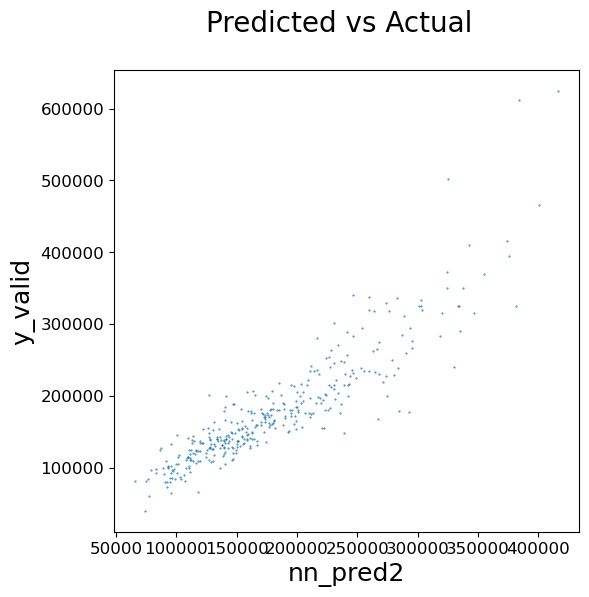

In [99]:
plt.figure(figsize=(6,6))
plt.scatter(nn_pred, y_validation, s = 0.2)
#plt.xlim(-100, 1200)
#plt.ylim(-100, 1200)
#plt.plot([-100, 1200], [-100, 1200], color='r', linestyle='-', linewidth=2)
plt.suptitle('Predicted vs Actual', fontsize=20)
plt.xlabel('nn_pred2', fontsize=18)
plt.ylabel('y_valid', fontsize=18)
plt.show()

In [100]:
accuracy(y_validation, nn_pred)

RMSE,MAE,R^2,RMSLE
33666.456965,22435.407071,0.809395,0.160429


Surprisingly the neural network performs roughly the same in this iteration compared to the decision tree. It can likely continue to be enhanced by refining the hidden layers.

### XGBoost without PCA

Given XGBoosts tendancy to overfit and produce negative values when it his given new data in the test set that it did not previously see in the train set, we will create a simple XGBoost model to start.

In [101]:
xgb_model = XGBRegressor(max_depth=10,
                          n_estimators = 50,
                          learning_rate=.1,
                          random_state=201,
                         booster='gbtree')

In [102]:
xgb_model.fit(X_train_tree, y_train_tree)
xgb_pred = xgb_model.predict(X_validation_tree)

In [103]:
pd.DataFrame({'Importance': xgb_model.feature_importances_}, index=X_train_tree.columns).sort_values(['Importance'], ascending=False)

,Importance
GarageCars,0.389681
FinalArea,0.273326
Bsmt_QC,0.053192
YearBuilt,0.039603
KitchenScore,0.039521
QC,0.027805
BsmtFinSF1,0.026752
GarageGrade,0.022737
GarageType,0.011227
ExterGrade,0.009887


In [104]:
accuracy(y_validation_tree, xgb_pred)

RMSE,MAE,R^2,RMSLE
30933.450715,16987.258134,0.839085,0.140238


Although the XGBoost can continue to be refined down to a .11 RMSLE, we risk overfitting so we will keep this initial version of the model.

### Light GBM without PCA

Finally we will produce a Light GBM model to determine how it compares against the others. Given that it has fewer issues as compared to the XGBoost when it overfits, we will refine this model for optimal performance.

In [105]:
lgb_model = LGBMRegressor(objective='regression',
                    learning_rate=0.05,
                    n_estimators=730,
                    num_leaves=8,
                    min_data_in_leaf=4,
                    max_depth=3,
                    max_bin=55,
                    bagging_fraction=0.78,
                    bagging_freq=5,
                    feature_fraction=0.24,
                    feature_fraction_seed=9,
                    bagging_seed=9,
                    min_sum_hessian_in_leaf=11)

In [106]:
lgb_model.fit(X_train_tree, y_train_tree)
lgb_pred = lgb_model.predict(X_validation_tree)

[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.78, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [107]:
pd.DataFrame({'Importance': lgb_model.feature_importances_}, index=X_train_tree.columns).sort_values(['Importance'], ascending=False)

,Importance
LotArea,356
GarageArea,309
QC,281
FinalArea,263
BsmtUnfSF,238
Neighborhood,191
BsmtFinSF1,178
YearBuilt,170
Porch,155
MoSold,152


In [108]:
accuracy(y_validation_tree, lgb_pred)

RMSE,MAE,R^2,RMSLE
23443.898494,15013.009114,0.907573,0.121822


## Ensemble models

Now we will ensemble our models together. We do so to assist in reducing bias that any one individual model has inherently built into it from the fitting process. To do so, we will run the fitted models on our full training data prior to developing a linear regression to weight each effectively.

### Add models into train df

We start by copying the dataset once more so not to make changes to the original data. We will utilize our ordinal encoder then rerun each of the models with the output prediction inserted into its own column.

In [109]:
#train_clean_ensemble = train_clean[train_clean.columns[1:]].copy()
train_clean_ensemble = train_clean.copy()
train_clean_ensemble

,SalePrice,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,PoolArea,FinalArea,GarageCars,MoSold,GarageGrade,KitchenScore,ExterGrade,QC,BR,Porch,Bsmt_QC,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,PoolQC,Fence,YrSold,SaleType,SaleCondition,Pool
0,208500,-3.192124,-1.054039,-0.571577,-0.971756,-0.290443,-1.286314,-3.314119,-3.449946,-2.427265,-2.211321,-0.070402,-3.126184,2,2,9,4,12,35,3.5,61,12,60,3.0,3.0,3.0,4.0,0.0,5.0,2.0,0.0,5.0,104.0,53.0,1.0,12.0,13.0,1.0,2.0,3.0,2.0,6.0,4.0,3.0,1.0,89.0,2.0,3.0,4.0,2.0,8.0,4.0,0.0
1,181500,-3.161179,-1.054027,-0.577593,-0.970448,-0.290443,-1.285627,-3.314119,-4.207495,-0.019426,-2.213247,-0.070402,-3.126472,2,5,9,3,9,48,2.5,298,12,20,3.0,3.0,3.0,2.0,0.0,24.0,1.0,0.0,2.0,77.0,26.0,1.0,8.0,8.0,2.0,1.0,1.0,0.0,6.0,4.0,5.0,1.0,62.0,2.0,3.0,4.0,1.0,8.0,4.0,0.0
2,223500,-3.185935,-1.054011,-0.572621,-0.972814,-0.290443,-1.284859,-3.314119,-4.207495,-0.019426,-2.210007,-0.070402,-3.126058,2,9,9,4,12,35,3.5,42,12,60,3.0,0.0,3.0,4.0,0.0,5.0,2.0,0.0,5.0,102.0,52.0,1.0,12.0,13.0,1.0,2.0,2.0,2.0,6.0,4.0,5.0,1.0,87.0,2.0,3.0,4.0,2.0,8.0,4.0,0.0
3,140000,-3.202439,-1.054028,-0.577593,-0.974113,-0.290443,-1.284315,-3.314119,-3.828720,-0.019426,-2.209263,-0.070402,-3.126235,3,2,9,4,9,35,2.0,307,12,70,3.0,0.0,3.0,0.0,0.0,6.0,2.0,0.0,5.0,19.0,20.0,1.0,13.0,15.0,2.0,0.0,3.0,0.0,6.0,3.0,2.0,5.0,84.0,3.0,3.0,4.0,0.0,8.0,0.0,0.0
4,250000,-3.152927,-1.053980,-0.566851,-0.972001,-0.290443,-1.284571,-1.810445,-3.071172,-0.019426,-2.205016,-0.070402,-3.125442,3,12,9,4,12,40,3.5,276,12,60,3.0,0.0,3.0,2.0,0.0,15.0,2.0,0.0,5.0,101.0,50.0,1.0,12.0,13.0,1.0,2.0,0.0,2.0,6.0,4.0,5.0,1.0,86.0,2.0,3.0,4.0,2.0,8.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,175000,-3.198313,-1.054044,-0.577593,-0.975152,-0.290443,-1.282199,-3.314119,-3.828720,-0.019426,-2.213247,-0.070402,-3.126201,2,8,9,3,9,30,2.5,40,12,60,3.0,3.0,3.0,4.0,0.0,8.0,2.0,0.0,5.0,100.0,50.0,1.0,12.0,13.0,2.0,2.0,3.0,6.0,6.0,4.0,5.0,1.0,85.0,2.0,3.0,4.0,1.0,8.0,4.0,0.0
1456,210000,-3.150863,-1.053991,-0.573940,-0.971352,-0.284175,-1.284064,-3.314119,-3.828720,2.388414,-2.212371,-0.070402,-3.125356,2,2,9,3,9,36,3.0,349,12,20,3.0,3.0,3.0,4.0,0.0,14.0,2.0,0.0,2.0,79.0,38.0,1.0,9.0,10.0,3.0,1.0,3.0,0.0,5.0,2.0,5.0,1.0,64.0,3.0,3.0,2.0,4.0,8.0,4.0,0.0
1457,266500,-3.190061,-1.054033,-0.577593,-0.973829,-0.290443,-1.282588,-1.810445,-3.071172,2.388414,-2.217800,-0.070402,-3.125272,1,5,9,4,20,63,2.0,60,12,70,3.0,3.0,3.0,4.0,0.0,6.0,2.0,0.0,5.0,44.0,56.0,1.0,5.0,5.0,2.0,4.0,3.0,2.0,6.0,4.0,2.0,1.0,29.0,2.0,3.0,0.0,4.0,8.0,4.0,0.0
1458,142125,-3.185935,-1.054026,-0.577593,-0.974917,-0.250875,-1.287083,-4.817792,-4.586269,-2.427265,-2.218063,-0.070402,-3.126795,1,4,9,4,9,30,2.0,478,9,20,3.0,3.0,3.0,4.0,0.0,12.0,2.0,0.0,2.0,51.0,46.0,3.0,8.0,8.0,2.0,1.0,2.0,2.0,5.0,3.0,3.0,1.0,36.0,3.0,3.0,4.0,4.0,8.0,4.0,0.0


In [110]:
#ordinal encoder
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
cat_col = ["MSZoning", "LotShape", "LandContour","LotConfig", 
           "LandSlope", "Neighborhood", "Condition1","BldgType", "HouseStyle", 
           "YearBuilt","YearRemodAdd", "RoofStyle", "Exterior1st", "Exterior2nd",
           "MasVnrType", "Foundation", "BsmtExposure", "BsmtFinType1",
           "BsmtFinType2","HeatingQC", "FireplaceQu", "GarageType", "GarageYrBlt",
           "GarageFinish","PoolQC","Fence","YrSold","SaleType","SaleCondition","Pool"]
ordinal_encoder.fit(train_clean_ensemble[cat_col])
ordinal_encoder.fit(train_clean_ensemble[cat_col])
train_clean_ensemble[cat_col] = ordinal_encoder.transform(train_clean_ensemble[cat_col])

In [111]:
#Add lightgb

#add lgb model as new columns
train_clean_ensemble['lgb_pred'] = lgb_model.predict(train_clean_ensemble[train_clean_ensemble.columns[1:]])

#move to front of df
column_to_move = train_clean_ensemble.pop("lgb_pred")
train_clean_ensemble.insert(0, "lgb_pred", column_to_move )

#view df
train_clean_ensemble.head()

,lgb_pred,SalePrice,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,PoolArea,FinalArea,GarageCars,MoSold,GarageGrade,KitchenScore,ExterGrade,QC,BR,Porch,Bsmt_QC,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,PoolQC,Fence,YrSold,SaleType,SaleCondition,Pool
0,199416.235671,208500,-3.192124,-1.054039,-0.571577,-0.971756,-0.290443,-1.286314,-3.314119,-3.449946,-2.427265,-2.211321,-0.070402,-3.126184,2,2,9,4,12,35,3.5,61,12,60,3.0,3.0,3.0,4.0,0.0,5.0,2.0,0.0,5.0,104.0,53.0,1.0,12.0,13.0,1.0,2.0,3.0,2.0,6.0,4.0,3.0,1.0,89.0,2.0,3.0,4.0,2.0,8.0,4.0,0.0
1,183226.557076,181500,-3.161179,-1.054027,-0.577593,-0.970448,-0.290443,-1.285627,-3.314119,-4.207495,-0.019426,-2.213247,-0.070402,-3.126472,2,5,9,3,9,48,2.5,298,12,20,3.0,3.0,3.0,2.0,0.0,24.0,1.0,0.0,2.0,77.0,26.0,1.0,8.0,8.0,2.0,1.0,1.0,0.0,6.0,4.0,5.0,1.0,62.0,2.0,3.0,4.0,1.0,8.0,4.0,0.0
2,216367.424899,223500,-3.185935,-1.054011,-0.572621,-0.972814,-0.290443,-1.284859,-3.314119,-4.207495,-0.019426,-2.210007,-0.070402,-3.126058,2,9,9,4,12,35,3.5,42,12,60,3.0,0.0,3.0,4.0,0.0,5.0,2.0,0.0,5.0,102.0,52.0,1.0,12.0,13.0,1.0,2.0,2.0,2.0,6.0,4.0,5.0,1.0,87.0,2.0,3.0,4.0,2.0,8.0,4.0,0.0
3,150974.955941,140000,-3.202439,-1.054028,-0.577593,-0.974113,-0.290443,-1.284315,-3.314119,-3.828720,-0.019426,-2.209263,-0.070402,-3.126235,3,2,9,4,9,35,2.0,307,12,70,3.0,0.0,3.0,0.0,0.0,6.0,2.0,0.0,5.0,19.0,20.0,1.0,13.0,15.0,2.0,0.0,3.0,0.0,6.0,3.0,2.0,5.0,84.0,3.0,3.0,4.0,0.0,8.0,0.0,0.0
4,312838.801952,250000,-3.152927,-1.053980,-0.566851,-0.972001,-0.290443,-1.284571,-1.810445,-3.071172,-0.019426,-2.205016,-0.070402,-3.125442,3,12,9,4,12,40,3.5,276,12,60,3.0,0.0,3.0,2.0,0.0,15.0,2.0,0.0,5.0,101.0,50.0,1.0,12.0,13.0,1.0,2.0,0.0,2.0,6.0,4.0,5.0,1.0,86.0,2.0,3.0,4.0,2.0,8.0,4.0,0.0


In [112]:
#add xgb

#add xgb model as new columns
train_clean_ensemble['xgb_model'] = xgb_model.predict(train_clean_ensemble[train_clean_ensemble.columns[2:]])

#move to front of df
column_to_move = train_clean_ensemble.pop("xgb_model")
train_clean_ensemble.insert(0, "xgb_model", column_to_move )

#view df
train_clean_ensemble.head()

,xgb_model,lgb_pred,SalePrice,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,PoolArea,FinalArea,GarageCars,MoSold,GarageGrade,KitchenScore,ExterGrade,QC,BR,Porch,Bsmt_QC,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,PoolQC,Fence,YrSold,SaleType,SaleCondition,Pool
0,207605.453125,199416.235671,208500,-3.192124,-1.054039,-0.571577,-0.971756,-0.290443,-1.286314,-3.314119,-3.449946,-2.427265,-2.211321,-0.070402,-3.126184,2,2,9,4,12,35,3.5,61,12,60,3.0,3.0,3.0,4.0,0.0,5.0,2.0,0.0,5.0,104.0,53.0,1.0,12.0,13.0,1.0,2.0,3.0,2.0,6.0,4.0,3.0,1.0,89.0,2.0,3.0,4.0,2.0,8.0,4.0,0.0
1,176659.765625,183226.557076,181500,-3.161179,-1.054027,-0.577593,-0.970448,-0.290443,-1.285627,-3.314119,-4.207495,-0.019426,-2.213247,-0.070402,-3.126472,2,5,9,3,9,48,2.5,298,12,20,3.0,3.0,3.0,2.0,0.0,24.0,1.0,0.0,2.0,77.0,26.0,1.0,8.0,8.0,2.0,1.0,1.0,0.0,6.0,4.0,5.0,1.0,62.0,2.0,3.0,4.0,1.0,8.0,4.0,0.0
2,219862.656250,216367.424899,223500,-3.185935,-1.054011,-0.572621,-0.972814,-0.290443,-1.284859,-3.314119,-4.207495,-0.019426,-2.210007,-0.070402,-3.126058,2,9,9,4,12,35,3.5,42,12,60,3.0,0.0,3.0,4.0,0.0,5.0,2.0,0.0,5.0,102.0,52.0,1.0,12.0,13.0,1.0,2.0,2.0,2.0,6.0,4.0,5.0,1.0,87.0,2.0,3.0,4.0,2.0,8.0,4.0,0.0
3,141030.187500,150974.955941,140000,-3.202439,-1.054028,-0.577593,-0.974113,-0.290443,-1.284315,-3.314119,-3.828720,-0.019426,-2.209263,-0.070402,-3.126235,3,2,9,4,9,35,2.0,307,12,70,3.0,0.0,3.0,0.0,0.0,6.0,2.0,0.0,5.0,19.0,20.0,1.0,13.0,15.0,2.0,0.0,3.0,0.0,6.0,3.0,2.0,5.0,84.0,3.0,3.0,4.0,0.0,8.0,0.0,0.0
4,276138.312500,312838.801952,250000,-3.152927,-1.053980,-0.566851,-0.972001,-0.290443,-1.284571,-1.810445,-3.071172,-0.019426,-2.205016,-0.070402,-3.125442,3,12,9,4,12,40,3.5,276,12,60,3.0,0.0,3.0,2.0,0.0,15.0,2.0,0.0,5.0,101.0,50.0,1.0,12.0,13.0,1.0,2.0,0.0,2.0,6.0,4.0,5.0,1.0,86.0,2.0,3.0,4.0,2.0,8.0,4.0,0.0


In [113]:
# add decision tree

#add dt model as new columns
train_clean_ensemble['dt_model'] = dt_model.predict(train_clean_ensemble[train_clean_ensemble.columns[3:]])

#move to front of df
column_to_move = train_clean_ensemble.pop("dt_model")
train_clean_ensemble.insert(0, "dt_model", column_to_move )

#view df
train_clean_ensemble.head()

,dt_model,xgb_model,lgb_pred,SalePrice,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,PoolArea,FinalArea,GarageCars,MoSold,GarageGrade,KitchenScore,ExterGrade,QC,BR,Porch,Bsmt_QC,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,PoolQC,Fence,YrSold,SaleType,SaleCondition,Pool
0,222726.555556,207605.453125,199416.235671,208500,-3.192124,-1.054039,-0.571577,-0.971756,-0.290443,-1.286314,-3.314119,-3.449946,-2.427265,-2.211321,-0.070402,-3.126184,2,2,9,4,12,35,3.5,61,12,60,3.0,3.0,3.0,4.0,0.0,5.0,2.0,0.0,5.0,104.0,53.0,1.0,12.0,13.0,1.0,2.0,3.0,2.0,6.0,4.0,3.0,1.0,89.0,2.0,3.0,4.0,2.0,8.0,4.0,0.0
1,168023.076923,176659.765625,183226.557076,181500,-3.161179,-1.054027,-0.577593,-0.970448,-0.290443,-1.285627,-3.314119,-4.207495,-0.019426,-2.213247,-0.070402,-3.126472,2,5,9,3,9,48,2.5,298,12,20,3.0,3.0,3.0,2.0,0.0,24.0,1.0,0.0,2.0,77.0,26.0,1.0,8.0,8.0,2.0,1.0,1.0,0.0,6.0,4.0,5.0,1.0,62.0,2.0,3.0,4.0,1.0,8.0,4.0,0.0
2,222726.555556,219862.656250,216367.424899,223500,-3.185935,-1.054011,-0.572621,-0.972814,-0.290443,-1.284859,-3.314119,-4.207495,-0.019426,-2.210007,-0.070402,-3.126058,2,9,9,4,12,35,3.5,42,12,60,3.0,0.0,3.0,4.0,0.0,5.0,2.0,0.0,5.0,102.0,52.0,1.0,12.0,13.0,1.0,2.0,2.0,2.0,6.0,4.0,5.0,1.0,87.0,2.0,3.0,4.0,2.0,8.0,4.0,0.0
3,143123.473684,141030.187500,150974.955941,140000,-3.202439,-1.054028,-0.577593,-0.974113,-0.290443,-1.284315,-3.314119,-3.828720,-0.019426,-2.209263,-0.070402,-3.126235,3,2,9,4,9,35,2.0,307,12,70,3.0,0.0,3.0,0.0,0.0,6.0,2.0,0.0,5.0,19.0,20.0,1.0,13.0,15.0,2.0,0.0,3.0,0.0,6.0,3.0,2.0,5.0,84.0,3.0,3.0,4.0,0.0,8.0,0.0,0.0
4,291664.250000,276138.312500,312838.801952,250000,-3.152927,-1.053980,-0.566851,-0.972001,-0.290443,-1.284571,-1.810445,-3.071172,-0.019426,-2.205016,-0.070402,-3.125442,3,12,9,4,12,40,3.5,276,12,60,3.0,0.0,3.0,2.0,0.0,15.0,2.0,0.0,5.0,101.0,50.0,1.0,12.0,13.0,1.0,2.0,0.0,2.0,6.0,4.0,5.0,1.0,86.0,2.0,3.0,4.0,2.0,8.0,4.0,0.0


In [114]:
# add random forest without pca

#add rf model as new columns
train_clean_ensemble['rf_model_nopca'] = rf_model_nopca.predict(train_clean_ensemble[train_clean_ensemble.columns[4:]])

#move to front of df
column_to_move = train_clean_ensemble.pop("rf_model_nopca")
train_clean_ensemble.insert(0, "rf_model_nopca", column_to_move )

#view df
train_clean_ensemble.head()

,rf_model_nopca,dt_model,xgb_model,lgb_pred,SalePrice,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,PoolArea,FinalArea,GarageCars,MoSold,GarageGrade,KitchenScore,ExterGrade,QC,BR,Porch,Bsmt_QC,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,PoolQC,Fence,YrSold,SaleType,SaleCondition,Pool
0,205985.798747,222726.555556,207605.453125,199416.235671,208500,-3.192124,-1.054039,-0.571577,-0.971756,-0.290443,-1.286314,-3.314119,-3.449946,-2.427265,-2.211321,-0.070402,-3.126184,2,2,9,4,12,35,3.5,61,12,60,3.0,3.0,3.0,4.0,0.0,5.0,2.0,0.0,5.0,104.0,53.0,1.0,12.0,13.0,1.0,2.0,3.0,2.0,6.0,4.0,3.0,1.0,89.0,2.0,3.0,4.0,2.0,8.0,4.0,0.0
1,177265.393741,168023.076923,176659.765625,183226.557076,181500,-3.161179,-1.054027,-0.577593,-0.970448,-0.290443,-1.285627,-3.314119,-4.207495,-0.019426,-2.213247,-0.070402,-3.126472,2,5,9,3,9,48,2.5,298,12,20,3.0,3.0,3.0,2.0,0.0,24.0,1.0,0.0,2.0,77.0,26.0,1.0,8.0,8.0,2.0,1.0,1.0,0.0,6.0,4.0,5.0,1.0,62.0,2.0,3.0,4.0,1.0,8.0,4.0,0.0
2,216411.119345,222726.555556,219862.656250,216367.424899,223500,-3.185935,-1.054011,-0.572621,-0.972814,-0.290443,-1.284859,-3.314119,-4.207495,-0.019426,-2.210007,-0.070402,-3.126058,2,9,9,4,12,35,3.5,42,12,60,3.0,0.0,3.0,4.0,0.0,5.0,2.0,0.0,5.0,102.0,52.0,1.0,12.0,13.0,1.0,2.0,2.0,2.0,6.0,4.0,5.0,1.0,87.0,2.0,3.0,4.0,2.0,8.0,4.0,0.0
3,161798.915214,143123.473684,141030.187500,150974.955941,140000,-3.202439,-1.054028,-0.577593,-0.974113,-0.290443,-1.284315,-3.314119,-3.828720,-0.019426,-2.209263,-0.070402,-3.126235,3,2,9,4,9,35,2.0,307,12,70,3.0,0.0,3.0,0.0,0.0,6.0,2.0,0.0,5.0,19.0,20.0,1.0,13.0,15.0,2.0,0.0,3.0,0.0,6.0,3.0,2.0,5.0,84.0,3.0,3.0,4.0,0.0,8.0,0.0,0.0
4,305115.435267,291664.250000,276138.312500,312838.801952,250000,-3.152927,-1.053980,-0.566851,-0.972001,-0.290443,-1.284571,-1.810445,-3.071172,-0.019426,-2.205016,-0.070402,-3.125442,3,12,9,4,12,40,3.5,276,12,60,3.0,0.0,3.0,2.0,0.0,15.0,2.0,0.0,5.0,101.0,50.0,1.0,12.0,13.0,1.0,2.0,0.0,2.0,6.0,4.0,5.0,1.0,86.0,2.0,3.0,4.0,2.0,8.0,4.0,0.0


In [115]:
# add neural network without pca

#add nn model as new columns
train_clean_ensemble['nn_model'] = nn_model.predict(train_clean_ensemble[train_clean_ensemble.columns[5:]])

#move to front of df
column_to_move = train_clean_ensemble.pop("nn_model")
train_clean_ensemble.insert(0, "nn_model", column_to_move )

#view df
train_clean_ensemble.head()

,nn_model,rf_model_nopca,dt_model,xgb_model,lgb_pred,SalePrice,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,PoolArea,FinalArea,GarageCars,MoSold,GarageGrade,KitchenScore,ExterGrade,QC,BR,Porch,Bsmt_QC,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,PoolQC,Fence,YrSold,SaleType,SaleCondition,Pool
0,196404.822845,205985.798747,222726.555556,207605.453125,199416.235671,208500,-3.192124,-1.054039,-0.571577,-0.971756,-0.290443,-1.286314,-3.314119,-3.449946,-2.427265,-2.211321,-0.070402,-3.126184,2,2,9,4,12,35,3.5,61,12,60,3.0,3.0,3.0,4.0,0.0,5.0,2.0,0.0,5.0,104.0,53.0,1.0,12.0,13.0,1.0,2.0,3.0,2.0,6.0,4.0,3.0,1.0,89.0,2.0,3.0,4.0,2.0,8.0,4.0,0.0
1,257378.757953,177265.393741,168023.076923,176659.765625,183226.557076,181500,-3.161179,-1.054027,-0.577593,-0.970448,-0.290443,-1.285627,-3.314119,-4.207495,-0.019426,-2.213247,-0.070402,-3.126472,2,5,9,3,9,48,2.5,298,12,20,3.0,3.0,3.0,2.0,0.0,24.0,1.0,0.0,2.0,77.0,26.0,1.0,8.0,8.0,2.0,1.0,1.0,0.0,6.0,4.0,5.0,1.0,62.0,2.0,3.0,4.0,1.0,8.0,4.0,0.0
2,207783.856682,216411.119345,222726.555556,219862.656250,216367.424899,223500,-3.185935,-1.054011,-0.572621,-0.972814,-0.290443,-1.284859,-3.314119,-4.207495,-0.019426,-2.210007,-0.070402,-3.126058,2,9,9,4,12,35,3.5,42,12,60,3.0,0.0,3.0,4.0,0.0,5.0,2.0,0.0,5.0,102.0,52.0,1.0,12.0,13.0,1.0,2.0,2.0,2.0,6.0,4.0,5.0,1.0,87.0,2.0,3.0,4.0,2.0,8.0,4.0,0.0
3,165363.340262,161798.915214,143123.473684,141030.187500,150974.955941,140000,-3.202439,-1.054028,-0.577593,-0.974113,-0.290443,-1.284315,-3.314119,-3.828720,-0.019426,-2.209263,-0.070402,-3.126235,3,2,9,4,9,35,2.0,307,12,70,3.0,0.0,3.0,0.0,0.0,6.0,2.0,0.0,5.0,19.0,20.0,1.0,13.0,15.0,2.0,0.0,3.0,0.0,6.0,3.0,2.0,5.0,84.0,3.0,3.0,4.0,0.0,8.0,0.0,0.0
4,279222.435543,305115.435267,291664.250000,276138.312500,312838.801952,250000,-3.152927,-1.053980,-0.566851,-0.972001,-0.290443,-1.284571,-1.810445,-3.071172,-0.019426,-2.205016,-0.070402,-3.125442,3,12,9,4,12,40,3.5,276,12,60,3.0,0.0,3.0,2.0,0.0,15.0,2.0,0.0,5.0,101.0,50.0,1.0,12.0,13.0,1.0,2.0,0.0,2.0,6.0,4.0,5.0,1.0,86.0,2.0,3.0,4.0,2.0,8.0,4.0,0.0


### Build OLS model

With all of our models to be used in the data, we will run the linear regression model to assess the weights each should receive in predicting the Sale Price effectively. 

In [116]:
#IP model
ensemble_ols_model = smf.ols(formula='SalePrice ~ xgb_model + lgb_pred + dt_model + rf_model_nopca + nn_model', data=train_clean_ensemble).fit()
ensemble_ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     9066.
Date:                Mon, 12 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:27:00   Log-Likelihood:                -16010.
No. Observations:                1460   AIC:                         3.203e+04
Df Residuals:                    1454   BIC:                         3.206e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2328.2363   1142.743     -2.037      0.042   -4569.838     -86.634
xgb_model          0.4893      0.030     16.434      0.000       0.431       0.548
lgb_pred           0.5652      0.037     15.475      0.000       0.494       0.637
dt_model           0.0489      0.019      2.631      0.009       0.012       0.085
rf_model_nopca    -0.0909      0.033     -2.791      0.005      -0.155      -0.027
nn_model           0.0068      0.015      0.445      0.656      -0.023       0.036
==============================================================================
Omnibus:                     1508.592   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           592339.561
Skew:                           4.238   Prob(JB):                         0.00
Kurtosis:                     101.312   Cond. No.                     1.35e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model appears to have strong performance and provides us with our coefficient weights to use for each model. We will write our ensemble model now with the weight inputs.

In [117]:
#ensemble model
train_clean_ensemble['ensemble_ols'] = (-2343.9877 + train_clean_ensemble['xgb_model']*0.4900 + train_clean_ensemble['lgb_pred']*0.5641 + 
                                       train_clean_ensemble['dt_model']*0.0491+ train_clean_ensemble['rf_model_nopca']*-0.0925 + train_clean_ensemble['nn_model']*0.0088)

In [118]:
print("Accuracy of ensemble_ols is:")
accuracy(train_clean_ensemble["SalePrice"], train_clean_ensemble["ensemble_ols"])

Accuracy of ensemble_ols is:


RMSE,MAE,R^2,RMSLE
14000.447083,7389.548020,0.968920,0.071153


It is positive to see that the ensembling of models together actually has out performed each individual model used as an input. This will be our ensemble moving forward for the test dataset.

# Reperform Cleaning on Train Data

The models have been fit and we have an excellent performance with our ensemble. Next, we need to follow our prior steps for the test data and run our ensemble model for the submission data.

## Data cleaning

First thing we do is repeat all of our data cleansing steps, including replacing nan or null values, consolidating fields, removing unnecessary or high mode attributes, and inserting numerical features in place of select categorical features.

In [119]:
test_clean = test.copy()

In [120]:
test_clean.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [121]:
#map categorical columns as numeric input
qual_list = {
    'Po': 1, 'Fa': 2,
    'PO' : 1, 'FA' : 2,
    'TA': 3, 'Gd': 4, 'Ex': 5
}
test_clean.GarageCond = test_clean.GarageCond.replace(pd.Series(qual_list).astype(str), regex=True)


In [122]:
#replace new NAs not previously issue in train
test_clean.MSZoning = test_clean.MSZoning.fillna('NA')
test_clean.Exterior1st = test_clean.Exterior1st.fillna('Other')
test_clean.Exterior2nd = test_clean.Exterior2nd.fillna('Other')
test_clean.BsmtFinType2 = test_clean.BsmtFinType2.fillna('NA')
test_clean.BsmtFinSF1 = test_clean.BsmtFinSF1.fillna(0)
test_clean.BsmtFinSF2 = test_clean.BsmtFinSF2.fillna(0)
test_clean.SaleType = test_clean.SaleType.fillna('Oth')

In [123]:
#map categorical columns as numeric input
qual_list = {
    'Po': 1, 'Fa': 2,
    'PO' : 1, 'FA' : 2,
    'TA': 3, 'Gd': 4, 'Ex': 5
}

#perform mapping for ExterQual, ExterCond, GarageQual, GarageCond, KitchenQual, HeatingQC, BsmtQual, BsmtCond
test_clean.ExterQual = test_clean.ExterQual.replace(pd.Series(qual_list).astype(str), regex=True)
test_clean.ExterCond = test_clean.ExterCond.replace(pd.Series(qual_list).astype(str), regex=True)
test_clean.GarageQual = test_clean.GarageQual.replace(pd.Series(qual_list).astype(str), regex=True)
test_clean.GarageCond = test_clean.GarageCond.replace(pd.Series(qual_list).astype(str), regex=True)
test_clean.KitchenQual = test_clean.KitchenQual.replace(pd.Series(qual_list).astype(str), regex=True)
test_clean.HeatingQC = test_clean.HeatingQC.replace(pd.Series(qual_list).astype(str), regex=True)
test_clean.BsmtQual = test_clean.BsmtQual.replace(pd.Series(qual_list).astype(str), regex=True)
test_clean.BsmtCond = test_clean.BsmtCond.replace(pd.Series(qual_list).astype(str), regex=True)

#property has central air
test_clean['CentralAir'] = np.where(test_clean['CentralAir']!= 'Y', 1, 0)

#property has pool
test_clean['Pool'] = np.where(test_clean['PoolArea'] > 0, 1, 0)

In [124]:
test_clean#replace nan with 0 indicating it does not exist OR prior to replacing with mean
test_clean.ExterQual = test_clean.ExterQual.fillna(0)
test_clean.ExterCond = test_clean.ExterCond.fillna(0)
test_clean.GarageQual = test_clean.GarageQual.fillna(0)
test_clean.GarageCond = test_clean.GarageCond.fillna(0)
test_clean.KitchenQual = test_clean.KitchenQual.fillna(0)
test_clean.HeatingQC = test_clean.HeatingQC.fillna(0)
test_clean.BsmtQual = test_clean.BsmtQual.fillna(0)
test_clean.BsmtCond = test_clean.BsmtCond.fillna(0)

#convert columns to int
test_clean.ExterQual = test_clean.ExterQual.astype(str).astype(int)
test_clean.ExterCond = test_clean.ExterCond.astype(str).astype(int)
test_clean.GarageQual = test_clean.GarageQual.astype(str).astype(int)
test_clean.GarageCond = test_clean.GarageCond.astype(str).astype(int)
test_clean.KitchenQual = test_clean.KitchenQual.astype(str).astype(int)
test_clean.HeatingQC = test_clean.HeatingQC.astype(str).astype(int)
test_clean.BsmtQual = test_clean.BsmtQual.astype(str).astype(int)
test_clean.BsmtCond = test_clean.BsmtCond.astype(str).astype(int)
test_clean.CentralAir = test_clean.CentralAir.astype(str).astype(int)

#replace select columns with mean as it is in house and exists
test_clean.KitchenQual=test_clean.KitchenQual.replace(0,test_clean.KitchenQual.mean())
test_clean.HeatingQC=test_clean.HeatingQC.replace(0,test_clean.HeatingQC.mean())


In [125]:
#consolidate garage and remove old columns
test_clean['GarageGrade'] = test_clean.GarageQual * test_clean.GarageCond
test_clean = test_clean.drop('GarageQual', axis=1)
test_clean = test_clean.drop('GarageCond', axis=1)

#consolidate kitchen and remove old columns
test_clean.KitchenQual=test_clean.KitchenQual.replace(0,test_clean.KitchenQual.mean())
test_clean['KitchenScore'] = test_clean.KitchenAbvGr * test_clean.KitchenQual
test_clean = test_clean.drop('KitchenAbvGr', axis=1)
test_clean = test_clean.drop('KitchenQual', axis=1)

#consolidate extergrade and remove old columns
test_clean['ExterGrade'] = test_clean.ExterQual * test_clean.ExterCond
test_clean = test_clean.drop('ExterQual', axis=1)
test_clean = test_clean.drop('ExterCond', axis=1)

#consolidate area
test_clean['FinalArea'] = test_clean['1stFlrSF'] + test_clean['2ndFlrSF'] + test_clean.TotalBsmtSF + test_clean.GrLivArea
test_clean = test_clean.drop('1stFlrSF', axis=1)
test_clean = test_clean.drop('2ndFlrSF', axis=1)
test_clean = test_clean.drop('TotalBsmtSF', axis=1)
test_clean = test_clean.drop('GrLivArea', axis=1)

#consolidate quality and remove old columns
test_clean['QC'] = test_clean.OverallCond * test_clean.OverallQual
test_clean = test_clean.drop('OverallCond', axis=1)
test_clean = test_clean.drop('OverallQual', axis=1)

#consolidate bathroom and remove old columns
test_clean['BR'] = test_clean.BsmtFullBath + (0.5 * test_clean.BsmtHalfBath) + test_clean.FullBath + (0.5 * test_clean.HalfBath)
test_clean = test_clean.drop('BsmtFullBath', axis=1)
test_clean = test_clean.drop('BsmtHalfBath', axis=1)
test_clean = test_clean.drop('FullBath', axis=1)
test_clean = test_clean.drop('HalfBath', axis=1)

#consolidate porch and remove old columns
test_clean['Porch'] = test_clean.OpenPorchSF + test_clean.EnclosedPorch + test_clean['3SsnPorch'] + test_clean.ScreenPorch + test_clean.WoodDeckSF
test_clean = test_clean.drop('OpenPorchSF', axis=1)
test_clean = test_clean.drop('EnclosedPorch', axis=1)
test_clean = test_clean.drop('3SsnPorch', axis=1)
test_clean = test_clean.drop('ScreenPorch', axis=1)
test_clean = test_clean.drop('WoodDeckSF', axis=1)

#consolidate basement quality and remove old columns
test_clean['Bsmt_QC'] = test_clean.BsmtCond * test_clean.BsmtQual
test_clean = test_clean.drop('BsmtCond', axis=1)
test_clean = test_clean.drop('BsmtQual', axis=1)

In [126]:
#replace NA values with 0 (not existent)
test_clean['GarageCars'].fillna(value=test_clean['GarageCars'].mean(), inplace=True)
test_clean['BsmtUnfSF'].fillna(value=test_clean['BsmtUnfSF'].mean(), inplace=True)
test_clean['LotFrontage'].fillna(value=test_clean['LotFrontage'].mean(), inplace=True)
test_clean['GarageArea'].fillna(value=test_clean['GarageArea'].mean(), inplace=True)
test_clean['MasVnrArea'].fillna(value=test_clean['MasVnrArea'].mean(), inplace=True)

#replace select columns with mean as it is in house and exists
test_clean.FinalArea=test_clean.FinalArea.replace(0,test_clean.FinalArea.mean())
test_clean.BR=test_clean.BR.replace(0,test_clean.BR.mean())

In [127]:
#remove high mode or not applicable features
test_clean = test_clean.drop('Street', axis=1)
test_clean = test_clean.drop('Alley', axis=1)
test_clean = test_clean.drop('Utilities', axis=1)
test_clean = test_clean.drop('Condition2', axis=1)
test_clean = test_clean.drop('RoofMatl', axis=1)
test_clean = test_clean.drop('Heating', axis=1)
test_clean = test_clean.drop('CentralAir', axis=1)
test_clean = test_clean.drop('Electrical', axis=1)
test_clean = test_clean.drop('LowQualFinSF', axis=1)
test_clean = test_clean.drop('Functional', axis=1)
test_clean = test_clean.drop('PavedDrive', axis=1)
test_clean = test_clean.drop('MiscVal', axis=1)
test_clean = test_clean.drop('MiscFeature', axis=1)

In [128]:
#clean up Garage Year Built
test_clean['GarageYrBlt'].fillna(value=test_clean['GarageYrBlt'].mean(), inplace=True)
test_clean.GarageYrBlt = test_clean.GarageYrBlt.astype(int)

In [130]:
#deal with remaining NaN values
test_clean['MasVnrType'] = test_clean['MasVnrType'].fillna('None')
test_clean['BsmtExposure'] = test_clean['BsmtExposure'].fillna('None')
test_clean['BsmtFinType1'] = test_clean['BsmtFinType1'].fillna('None')
test_clean['BsmtFinType2'] = test_clean['BsmtFinType2'].fillna('None')
test_clean['FireplaceQu'] = test_clean['FireplaceQu'].fillna('None')
test_clean['GarageType'] = test_clean['GarageType'].fillna('None')
test_clean['GarageFinish'] = test_clean['GarageFinish'].fillna('None')
test_clean['PoolQC'] = test_clean['PoolQC'].fillna('None')
test_clean['Fence'] = test_clean['Fence'].fillna('None')

In [131]:
test_clean.FinalArea = test_clean.FinalArea.fillna(0)
test_clean.BR = test_clean.BR.fillna(0)

In [132]:
summarize_dataframe(test_clean)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,int64,0,1459,1459.0,,,,2190.0,421.321334,1461.0,1825.5,2190.0,2554.5,2919.0
MSSubClass,int64,0,16,1459.0,,,,57.378341,42.74688,20.0,20.0,50.0,70.0,190.0
MSZoning,object,0,6,1459.0,6,RL,1114,,,,,,,
LotFrontage,float64,0,116,1459.0,,,,68.580357,20.561228,21.0,60.0,68.580357,78.0,200.0
LotArea,int64,0,1106,1459.0,,,,9819.161069,4955.517327,1470.0,7391.0,9399.0,11517.5,56600.0
LotShape,object,0,4,1459.0,4,Reg,934,,,,,,,
LandContour,object,0,4,1459.0,4,Lvl,1311,,,,,,,
LotConfig,object,0,5,1459.0,5,Inside,1081,,,,,,,
LandSlope,object,0,3,1459.0,3,Gtl,1396,,,,,,,
Neighborhood,object,0,25,1459.0,25,NAmes,218,,,,,,,


## Scale continuous features

Similar to how we scaled features in the training data, let us scale those same features in test so that python is not incorrectly fitting the model trying to compare large and small features against one another.

In [133]:
continuous_features = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", 
                            "BsmtUnfSF", "BedroomAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageArea", "PoolArea", "FinalArea"]

In [134]:
scaler = StandardScaler()
scaler.fit(test_clean[continuous_features])

StandardScaler()

In [135]:
test_clean[continuous_features] = scaler.transform(test_clean[continuous_features])

In [136]:
test_clean[continuous_features] = scaler.transform(test_clean[continuous_features])

In [137]:
test_clean.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,Foundation,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,HeatingQC,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PoolArea,PoolQC,Fence,MoSold,YrSold,SaleType,SaleCondition,Pool,GarageGrade,KitchenScore,ExterGrade,FinalArea,QC,BR,Porch,Bsmt_QC
0,1461,20,RH,-3.309535,-1.982066,Reg,Lvl,Inside,Gtl,NAmes,Feedr,1Fam,1Story,1961,1961,Gable,VinylSd,VinylSd,None,-0.573335,CBlock,No,Rec,-0.964267,LwQ,-0.294759,-1.270013,3,-4.681777,-4.841978,-2.285659,None,Attchd,1961,Unf,1.0,-2.174197,-0.059104,None,MnPrv,6,2010,WD,Normal,0,9,3.0,9,-3.254869,30,1.0,260,9
1,1462,20,RL,-3.307168,-1.981958,IR1,Lvl,Corner,Gtl,NAmes,Norm,1Fam,1Story,1958,1958,Hip,Wd Sdng,Wd Sdng,BrkFace,-0.569874,CBlock,No,ALQ,-0.962070,Unf,-0.299375,-1.269300,3,-3.228450,-4.402457,-2.285659,None,Attchd,1958,Unf,1.0,-2.183082,-0.059104,None,None,6,2010,WD,Normal,0,9,4.0,9,-3.254006,36,1.5,429,9
2,1463,60,RL,-3.323737,-1.981976,IR1,Lvl,Inside,Gtl,Gilbert,Norm,1Fam,2Story,1997,1998,Gable,VinylSd,VinylSd,None,-0.573335,PConc,No,GLQ,-0.962707,Unf,-0.299375,-1.270709,4,-3.228450,-4.402457,0.101740,TA,Attchd,1997,Fin,2.0,-2.179469,-0.059104,None,MnPrv,3,2010,WD,Normal,0,9,3.0,9,-3.253875,25,2.5,246,12
3,1464,60,RL,-3.314269,-1.982133,IR1,Lvl,Inside,Gtl,Gilbert,Norm,1Fam,2Story,1998,1998,Gable,VinylSd,VinylSd,BrkFace,-0.572694,PConc,No,GLQ,-0.963620,Unf,-0.299375,-1.269730,5,-3.228450,-3.962935,0.101740,Gd,Attchd,1998,Fin,2.0,-2.179724,-0.059104,None,None,6,2010,WD,Normal,0,9,4.0,9,-3.253909,36,2.5,396,9
4,1465,120,RL,-3.397114,-1.982336,IR1,HLS,Inside,Gtl,StoneBr,Norm,TwnhsE,1Story,1992,1992,Gable,HdBoard,HdBoard,None,-0.573335,PConc,No,ALQ,-0.965256,Unf,-0.299375,-1.266100,5,-4.681777,-4.841978,-2.285659,None,Attchd,1992,RFn,2.0,-2.178959,-0.059104,None,None,1,2010,WD,Normal,0,9,4.0,12,-3.254102,40,2.0,226,12


## Arrange columns

To assist with the modeling process moving forward, we will rearrange the features to group the categorical, continuous, and label.

In [138]:
#categorize columns in continuous, categorical, y

cont_col = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1','BsmtFinSF2', 
            'BsmtUnfSF', 'BedroomAbvGr', 'TotRmsAbvGrd','Fireplaces', 'GarageArea', 
            'PoolArea','FinalArea', 'GarageCars','MoSold','GarageGrade','KitchenScore',
            'ExterGrade','QC','BR','Porch','Bsmt_QC']

cat_col = ["MSZoning", "LotShape", "LandContour","LotConfig", 
           "LandSlope", "Neighborhood", "Condition1","BldgType", "HouseStyle", 
           "YearBuilt","YearRemodAdd", "RoofStyle", "Exterior1st", "Exterior2nd",
           "MasVnrType", "Foundation", "BsmtExposure", "BsmtFinType1",
           "BsmtFinType2","HeatingQC", "FireplaceQu", "GarageType", "GarageYrBlt",
           "GarageFinish","PoolQC","Fence","YrSold","SaleType","SaleCondition","Pool"]



In [139]:
#rearrange columns
test_clean = test_clean.reindex(['Id', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1','BsmtFinSF2', 
                                   'BsmtUnfSF', 'BedroomAbvGr', 'TotRmsAbvGrd','Fireplaces', 'GarageArea', 
                                   'PoolArea','FinalArea', 'GarageCars','MoSold','GarageGrade','KitchenScore',
                                   'ExterGrade','QC','BR','Porch','Bsmt_QC','MSSubClass', 'MSZoning', 'LotShape', 'LandContour','LotConfig', 
                                   'LandSlope', 'Neighborhood', 'Condition1','BldgType', 'HouseStyle', 
                                   'YearBuilt','YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd',
                                   'MasVnrType', 'Foundation', 'BsmtExposure', 'BsmtFinType1',
                                   'BsmtFinType2','HeatingQC', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
                                   'GarageFinish','PoolQC','Fence','YrSold','SaleType','SaleCondition','Pool'], 
                                  axis = 1)


In [140]:
test_clean.head()

,Id,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,PoolArea,FinalArea,GarageCars,MoSold,GarageGrade,KitchenScore,ExterGrade,QC,BR,Porch,Bsmt_QC,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,PoolQC,Fence,YrSold,SaleType,SaleCondition,Pool
0,1461,-3.309535,-1.982066,-0.573335,-0.964267,-0.294759,-1.270013,-4.681777,-4.841978,-2.285659,-2.174197,-0.059104,-3.254869,1.0,6,9,3.0,9,30,1.0,260,9,20,RH,Reg,Lvl,Inside,Gtl,NAmes,Feedr,1Fam,1Story,1961,1961,Gable,VinylSd,VinylSd,None,CBlock,No,Rec,LwQ,3,None,Attchd,1961,Unf,None,MnPrv,2010,WD,Normal,0
1,1462,-3.307168,-1.981958,-0.569874,-0.962070,-0.299375,-1.269300,-3.228450,-4.402457,-2.285659,-2.183082,-0.059104,-3.254006,1.0,6,9,4.0,9,36,1.5,429,9,20,RL,IR1,Lvl,Corner,Gtl,NAmes,Norm,1Fam,1Story,1958,1958,Hip,Wd Sdng,Wd Sdng,BrkFace,CBlock,No,ALQ,Unf,3,None,Attchd,1958,Unf,None,None,2010,WD,Normal,0
2,1463,-3.323737,-1.981976,-0.573335,-0.962707,-0.299375,-1.270709,-3.228450,-4.402457,0.101740,-2.179469,-0.059104,-3.253875,2.0,3,9,3.0,9,25,2.5,246,12,60,RL,IR1,Lvl,Inside,Gtl,Gilbert,Norm,1Fam,2Story,1997,1998,Gable,VinylSd,VinylSd,None,PConc,No,GLQ,Unf,4,TA,Attchd,1997,Fin,None,MnPrv,2010,WD,Normal,0
3,1464,-3.314269,-1.982133,-0.572694,-0.963620,-0.299375,-1.269730,-3.228450,-3.962935,0.101740,-2.179724,-0.059104,-3.253909,2.0,6,9,4.0,9,36,2.5,396,9,60,RL,IR1,Lvl,Inside,Gtl,Gilbert,Norm,1Fam,2Story,1998,1998,Gable,VinylSd,VinylSd,BrkFace,PConc,No,GLQ,Unf,5,Gd,Attchd,1998,Fin,None,None,2010,WD,Normal,0
4,1465,-3.397114,-1.982336,-0.573335,-0.965256,-0.299375,-1.266100,-4.681777,-4.841978,-2.285659,-2.178959,-0.059104,-3.254102,2.0,1,9,4.0,12,40,2.0,226,12,120,RL,IR1,HLS,Inside,Gtl,StoneBr,Norm,TwnhsE,1Story,1992,1992,Gable,HdBoard,HdBoard,None,PConc,No,ALQ,Unf,5,None,Attchd,1992,RFn,None,None,2010,WD,Normal,0


## Set ordinal encoder for test

Similar to how we set an ordinal encoder for features in the training data, let us do the same for those same features in test so that python can utilize the categorical features with the regression models.

In [141]:
test_clean[cat_col] = ordinal_encoder1.transform(test_clean[cat_col])

In [142]:
test_clean.head()

,Id,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,PoolArea,FinalArea,GarageCars,MoSold,GarageGrade,KitchenScore,ExterGrade,QC,BR,Porch,Bsmt_QC,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,PoolQC,Fence,YrSold,SaleType,SaleCondition,Pool
0,1461,-3.309535,-1.982066,-0.573335,-0.964267,-0.294759,-1.270013,-4.681777,-4.841978,-2.285659,-2.174197,-0.059104,-3.254869,1.0,6,9,3.0,9,30,1.0,260,9,20,2.0,3.0,3.0,4.0,0.0,12.0,1.0,0.0,2.0,62.0,11.0,1.0,12.0,13.0,2.0,1.0,3.0,5.0,3.0,2.0,3.0,1.0,47.0,3.0,3.0,2.0,4.0,8.0,4.0,0.0
1,1462,-3.307168,-1.981958,-0.569874,-0.962070,-0.299375,-1.269300,-3.228450,-4.402457,-2.285659,-2.183082,-0.059104,-3.254006,1.0,6,9,4.0,9,36,1.5,429,9,20,3.0,0.0,3.0,0.0,0.0,12.0,2.0,0.0,2.0,59.0,8.0,3.0,13.0,14.0,1.0,1.0,3.0,0.0,6.0,2.0,3.0,1.0,44.0,3.0,3.0,4.0,4.0,8.0,4.0,0.0
2,1463,-3.323737,-1.981976,-0.573335,-0.962707,-0.299375,-1.270709,-3.228450,-4.402457,0.101740,-2.179469,-0.059104,-3.253875,2.0,3,9,3.0,9,25,2.5,246,12,60,3.0,0.0,3.0,4.0,0.0,8.0,2.0,0.0,5.0,98.0,48.0,1.0,12.0,13.0,2.0,2.0,3.0,2.0,6.0,3.0,5.0,1.0,83.0,0.0,3.0,2.0,4.0,8.0,4.0,0.0
3,1464,-3.314269,-1.982133,-0.572694,-0.963620,-0.299375,-1.269730,-3.228450,-3.962935,0.101740,-2.179724,-0.059104,-3.253909,2.0,6,9,4.0,9,36,2.5,396,9,60,3.0,0.0,3.0,4.0,0.0,8.0,2.0,0.0,5.0,99.0,48.0,1.0,12.0,13.0,1.0,2.0,3.0,2.0,6.0,4.0,2.0,1.0,84.0,0.0,3.0,4.0,4.0,8.0,4.0,0.0
4,1465,-3.397114,-1.982336,-0.573335,-0.965256,-0.299375,-1.266100,-4.681777,-4.841978,-2.285659,-2.178959,-0.059104,-3.254102,2.0,1,9,4.0,12,40,2.0,226,12,120,3.0,0.0,1.0,4.0,0.0,22.0,2.0,4.0,2.0,93.0,42.0,1.0,6.0,6.0,2.0,2.0,3.0,0.0,6.0,4.0,3.0,1.0,78.0,2.0,3.0,4.0,4.0,8.0,4.0,0.0


## Run models on test data

Finally, let us rerun the same fitted models again the clean test data.

In [143]:
#add lgb model as new columns
test_clean['lgb_pred'] = lgb_model.predict(test_clean[test_clean.columns[1:]])

#move to front of df
column_to_move = test_clean.pop("lgb_pred")
test_clean.insert(0, "lgb_pred", column_to_move )

#view df
test_clean.head()

,lgb_pred,Id,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,PoolArea,FinalArea,GarageCars,MoSold,GarageGrade,KitchenScore,ExterGrade,QC,BR,Porch,Bsmt_QC,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,PoolQC,Fence,YrSold,SaleType,SaleCondition,Pool
0,135439.051423,1461,-3.309535,-1.982066,-0.573335,-0.964267,-0.294759,-1.270013,-4.681777,-4.841978,-2.285659,-2.174197,-0.059104,-3.254869,1.0,6,9,3.0,9,30,1.0,260,9,20,2.0,3.0,3.0,4.0,0.0,12.0,1.0,0.0,2.0,62.0,11.0,1.0,12.0,13.0,2.0,1.0,3.0,5.0,3.0,2.0,3.0,1.0,47.0,3.0,3.0,2.0,4.0,8.0,4.0,0.0
1,169774.279234,1462,-3.307168,-1.981958,-0.569874,-0.962070,-0.299375,-1.269300,-3.228450,-4.402457,-2.285659,-2.183082,-0.059104,-3.254006,1.0,6,9,4.0,9,36,1.5,429,9,20,3.0,0.0,3.0,0.0,0.0,12.0,2.0,0.0,2.0,59.0,8.0,3.0,13.0,14.0,1.0,1.0,3.0,0.0,6.0,2.0,3.0,1.0,44.0,3.0,3.0,4.0,4.0,8.0,4.0,0.0
2,203595.680401,1463,-3.323737,-1.981976,-0.573335,-0.962707,-0.299375,-1.270709,-3.228450,-4.402457,0.101740,-2.179469,-0.059104,-3.253875,2.0,3,9,3.0,9,25,2.5,246,12,60,3.0,0.0,3.0,4.0,0.0,8.0,2.0,0.0,5.0,98.0,48.0,1.0,12.0,13.0,2.0,2.0,3.0,2.0,6.0,3.0,5.0,1.0,83.0,0.0,3.0,2.0,4.0,8.0,4.0,0.0
3,219206.762409,1464,-3.314269,-1.982133,-0.572694,-0.963620,-0.299375,-1.269730,-3.228450,-3.962935,0.101740,-2.179724,-0.059104,-3.253909,2.0,6,9,4.0,9,36,2.5,396,9,60,3.0,0.0,3.0,4.0,0.0,8.0,2.0,0.0,5.0,99.0,48.0,1.0,12.0,13.0,1.0,2.0,3.0,2.0,6.0,4.0,2.0,1.0,84.0,0.0,3.0,4.0,4.0,8.0,4.0,0.0
4,216980.202815,1465,-3.397114,-1.982336,-0.573335,-0.965256,-0.299375,-1.266100,-4.681777,-4.841978,-2.285659,-2.178959,-0.059104,-3.254102,2.0,1,9,4.0,12,40,2.0,226,12,120,3.0,0.0,1.0,4.0,0.0,22.0,2.0,4.0,2.0,93.0,42.0,1.0,6.0,6.0,2.0,2.0,3.0,0.0,6.0,4.0,3.0,1.0,78.0,2.0,3.0,4.0,4.0,8.0,4.0,0.0


In [144]:
#add xgb model as new columns
test_clean['xgb_model'] = xgb_model.predict(test_clean[test_clean.columns[2:]])

#move to front of df
column_to_move = test_clean.pop("xgb_model")
test_clean.insert(0, "xgb_model", column_to_move )

#view df
test_clean.head()

,xgb_model,lgb_pred,Id,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,PoolArea,FinalArea,GarageCars,MoSold,GarageGrade,KitchenScore,ExterGrade,QC,BR,Porch,Bsmt_QC,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,PoolQC,Fence,YrSold,SaleType,SaleCondition,Pool
0,81313.414062,135439.051423,1461,-3.309535,-1.982066,-0.573335,-0.964267,-0.294759,-1.270013,-4.681777,-4.841978,-2.285659,-2.174197,-0.059104,-3.254869,1.0,6,9,3.0,9,30,1.0,260,9,20,2.0,3.0,3.0,4.0,0.0,12.0,1.0,0.0,2.0,62.0,11.0,1.0,12.0,13.0,2.0,1.0,3.0,5.0,3.0,2.0,3.0,1.0,47.0,3.0,3.0,2.0,4.0,8.0,4.0,0.0
1,86722.609375,169774.279234,1462,-3.307168,-1.981958,-0.569874,-0.962070,-0.299375,-1.269300,-3.228450,-4.402457,-2.285659,-2.183082,-0.059104,-3.254006,1.0,6,9,4.0,9,36,1.5,429,9,20,3.0,0.0,3.0,0.0,0.0,12.0,2.0,0.0,2.0,59.0,8.0,3.0,13.0,14.0,1.0,1.0,3.0,0.0,6.0,2.0,3.0,1.0,44.0,3.0,3.0,4.0,4.0,8.0,4.0,0.0
2,108854.781250,203595.680401,1463,-3.323737,-1.981976,-0.573335,-0.962707,-0.299375,-1.270709,-3.228450,-4.402457,0.101740,-2.179469,-0.059104,-3.253875,2.0,3,9,3.0,9,25,2.5,246,12,60,3.0,0.0,3.0,4.0,0.0,8.0,2.0,0.0,5.0,98.0,48.0,1.0,12.0,13.0,2.0,2.0,3.0,2.0,6.0,3.0,5.0,1.0,83.0,0.0,3.0,2.0,4.0,8.0,4.0,0.0
3,110725.851562,219206.762409,1464,-3.314269,-1.982133,-0.572694,-0.963620,-0.299375,-1.269730,-3.228450,-3.962935,0.101740,-2.179724,-0.059104,-3.253909,2.0,6,9,4.0,9,36,2.5,396,9,60,3.0,0.0,3.0,4.0,0.0,8.0,2.0,0.0,5.0,99.0,48.0,1.0,12.0,13.0,1.0,2.0,3.0,2.0,6.0,4.0,2.0,1.0,84.0,0.0,3.0,4.0,4.0,8.0,4.0,0.0
4,103864.914062,216980.202815,1465,-3.397114,-1.982336,-0.573335,-0.965256,-0.299375,-1.266100,-4.681777,-4.841978,-2.285659,-2.178959,-0.059104,-3.254102,2.0,1,9,4.0,12,40,2.0,226,12,120,3.0,0.0,1.0,4.0,0.0,22.0,2.0,4.0,2.0,93.0,42.0,1.0,6.0,6.0,2.0,2.0,3.0,0.0,6.0,4.0,3.0,1.0,78.0,2.0,3.0,4.0,4.0,8.0,4.0,0.0


In [145]:
#add dt model as new columns
test_clean['dt_model'] = dt_model.predict(test_clean[test_clean.columns[3:]])

#move to front of df
column_to_move = test_clean.pop("dt_model")
test_clean.insert(0, "dt_model", column_to_move )

#view df
test_clean.head()

,dt_model,xgb_model,lgb_pred,Id,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,PoolArea,FinalArea,GarageCars,MoSold,GarageGrade,KitchenScore,ExterGrade,QC,BR,Porch,Bsmt_QC,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,PoolQC,Fence,YrSold,SaleType,SaleCondition,Pool
0,86172.727273,81313.414062,135439.051423,1461,-3.309535,-1.982066,-0.573335,-0.964267,-0.294759,-1.270013,-4.681777,-4.841978,-2.285659,-2.174197,-0.059104,-3.254869,1.0,6,9,3.0,9,30,1.0,260,9,20,2.0,3.0,3.0,4.0,0.0,12.0,1.0,0.0,2.0,62.0,11.0,1.0,12.0,13.0,2.0,1.0,3.0,5.0,3.0,2.0,3.0,1.0,47.0,3.0,3.0,2.0,4.0,8.0,4.0,0.0
1,86172.727273,86722.609375,169774.279234,1462,-3.307168,-1.981958,-0.569874,-0.962070,-0.299375,-1.269300,-3.228450,-4.402457,-2.285659,-2.183082,-0.059104,-3.254006,1.0,6,9,4.0,9,36,1.5,429,9,20,3.0,0.0,3.0,0.0,0.0,12.0,2.0,0.0,2.0,59.0,8.0,3.0,13.0,14.0,1.0,1.0,3.0,0.0,6.0,2.0,3.0,1.0,44.0,3.0,3.0,4.0,4.0,8.0,4.0,0.0
2,86172.727273,108854.781250,203595.680401,1463,-3.323737,-1.981976,-0.573335,-0.962707,-0.299375,-1.270709,-3.228450,-4.402457,0.101740,-2.179469,-0.059104,-3.253875,2.0,3,9,3.0,9,25,2.5,246,12,60,3.0,0.0,3.0,4.0,0.0,8.0,2.0,0.0,5.0,98.0,48.0,1.0,12.0,13.0,2.0,2.0,3.0,2.0,6.0,3.0,5.0,1.0,83.0,0.0,3.0,2.0,4.0,8.0,4.0,0.0
3,86172.727273,110725.851562,219206.762409,1464,-3.314269,-1.982133,-0.572694,-0.963620,-0.299375,-1.269730,-3.228450,-3.962935,0.101740,-2.179724,-0.059104,-3.253909,2.0,6,9,4.0,9,36,2.5,396,9,60,3.0,0.0,3.0,4.0,0.0,8.0,2.0,0.0,5.0,99.0,48.0,1.0,12.0,13.0,1.0,2.0,3.0,2.0,6.0,4.0,2.0,1.0,84.0,0.0,3.0,4.0,4.0,8.0,4.0,0.0
4,86172.727273,103864.914062,216980.202815,1465,-3.397114,-1.982336,-0.573335,-0.965256,-0.299375,-1.266100,-4.681777,-4.841978,-2.285659,-2.178959,-0.059104,-3.254102,2.0,1,9,4.0,12,40,2.0,226,12,120,3.0,0.0,1.0,4.0,0.0,22.0,2.0,4.0,2.0,93.0,42.0,1.0,6.0,6.0,2.0,2.0,3.0,0.0,6.0,4.0,3.0,1.0,78.0,2.0,3.0,4.0,4.0,8.0,4.0,0.0


In [146]:
#add rf_model_nopca model as new columns
test_clean['rf_model_nopca'] = rf_model_nopca.predict(test_clean[test_clean.columns[4:]])

#move to front of df
column_to_move = test_clean.pop("rf_model_nopca")
test_clean.insert(0, "rf_model_nopca", column_to_move )

#view df
test_clean.head()

,rf_model_nopca,dt_model,xgb_model,lgb_pred,Id,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,PoolArea,FinalArea,GarageCars,MoSold,GarageGrade,KitchenScore,ExterGrade,QC,BR,Porch,Bsmt_QC,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,PoolQC,Fence,YrSold,SaleType,SaleCondition,Pool
0,123136.439101,86172.727273,81313.414062,135439.051423,1461,-3.309535,-1.982066,-0.573335,-0.964267,-0.294759,-1.270013,-4.681777,-4.841978,-2.285659,-2.174197,-0.059104,-3.254869,1.0,6,9,3.0,9,30,1.0,260,9,20,2.0,3.0,3.0,4.0,0.0,12.0,1.0,0.0,2.0,62.0,11.0,1.0,12.0,13.0,2.0,1.0,3.0,5.0,3.0,2.0,3.0,1.0,47.0,3.0,3.0,2.0,4.0,8.0,4.0,0.0
1,135122.546877,86172.727273,86722.609375,169774.279234,1462,-3.307168,-1.981958,-0.569874,-0.962070,-0.299375,-1.269300,-3.228450,-4.402457,-2.285659,-2.183082,-0.059104,-3.254006,1.0,6,9,4.0,9,36,1.5,429,9,20,3.0,0.0,3.0,0.0,0.0,12.0,2.0,0.0,2.0,59.0,8.0,3.0,13.0,14.0,1.0,1.0,3.0,0.0,6.0,2.0,3.0,1.0,44.0,3.0,3.0,4.0,4.0,8.0,4.0,0.0
2,189387.735855,86172.727273,108854.781250,203595.680401,1463,-3.323737,-1.981976,-0.573335,-0.962707,-0.299375,-1.270709,-3.228450,-4.402457,0.101740,-2.179469,-0.059104,-3.253875,2.0,3,9,3.0,9,25,2.5,246,12,60,3.0,0.0,3.0,4.0,0.0,8.0,2.0,0.0,5.0,98.0,48.0,1.0,12.0,13.0,2.0,2.0,3.0,2.0,6.0,3.0,5.0,1.0,83.0,0.0,3.0,2.0,4.0,8.0,4.0,0.0
3,193983.591159,86172.727273,110725.851562,219206.762409,1464,-3.314269,-1.982133,-0.572694,-0.963620,-0.299375,-1.269730,-3.228450,-3.962935,0.101740,-2.179724,-0.059104,-3.253909,2.0,6,9,4.0,9,36,2.5,396,9,60,3.0,0.0,3.0,4.0,0.0,8.0,2.0,0.0,5.0,99.0,48.0,1.0,12.0,13.0,1.0,2.0,3.0,2.0,6.0,4.0,2.0,1.0,84.0,0.0,3.0,4.0,4.0,8.0,4.0,0.0
4,200020.217029,86172.727273,103864.914062,216980.202815,1465,-3.397114,-1.982336,-0.573335,-0.965256,-0.299375,-1.266100,-4.681777,-4.841978,-2.285659,-2.178959,-0.059104,-3.254102,2.0,1,9,4.0,12,40,2.0,226,12,120,3.0,0.0,1.0,4.0,0.0,22.0,2.0,4.0,2.0,93.0,42.0,1.0,6.0,6.0,2.0,2.0,3.0,0.0,6.0,4.0,3.0,1.0,78.0,2.0,3.0,4.0,4.0,8.0,4.0,0.0


In [147]:
#add nn_model model as new columns
test_clean['nn_model'] = nn_model.predict(test_clean[test_clean.columns[5:]])

#move to front of df
column_to_move = test_clean.pop("nn_model")
test_clean.insert(0, "nn_model", column_to_move )

#view df
test_clean.head()

,nn_model,rf_model_nopca,dt_model,xgb_model,lgb_pred,Id,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,PoolArea,FinalArea,GarageCars,MoSold,GarageGrade,KitchenScore,ExterGrade,QC,BR,Porch,Bsmt_QC,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,PoolQC,Fence,YrSold,SaleType,SaleCondition,Pool
0,117006.219892,123136.439101,86172.727273,81313.414062,135439.051423,1461,-3.309535,-1.982066,-0.573335,-0.964267,-0.294759,-1.270013,-4.681777,-4.841978,-2.285659,-2.174197,-0.059104,-3.254869,1.0,6,9,3.0,9,30,1.0,260,9,20,2.0,3.0,3.0,4.0,0.0,12.0,1.0,0.0,2.0,62.0,11.0,1.0,12.0,13.0,2.0,1.0,3.0,5.0,3.0,2.0,3.0,1.0,47.0,3.0,3.0,2.0,4.0,8.0,4.0,0.0
1,149647.786742,135122.546877,86172.727273,86722.609375,169774.279234,1462,-3.307168,-1.981958,-0.569874,-0.962070,-0.299375,-1.269300,-3.228450,-4.402457,-2.285659,-2.183082,-0.059104,-3.254006,1.0,6,9,4.0,9,36,1.5,429,9,20,3.0,0.0,3.0,0.0,0.0,12.0,2.0,0.0,2.0,59.0,8.0,3.0,13.0,14.0,1.0,1.0,3.0,0.0,6.0,2.0,3.0,1.0,44.0,3.0,3.0,4.0,4.0,8.0,4.0,0.0
2,171144.900858,189387.735855,86172.727273,108854.781250,203595.680401,1463,-3.323737,-1.981976,-0.573335,-0.962707,-0.299375,-1.270709,-3.228450,-4.402457,0.101740,-2.179469,-0.059104,-3.253875,2.0,3,9,3.0,9,25,2.5,246,12,60,3.0,0.0,3.0,4.0,0.0,8.0,2.0,0.0,5.0,98.0,48.0,1.0,12.0,13.0,2.0,2.0,3.0,2.0,6.0,3.0,5.0,1.0,83.0,0.0,3.0,2.0,4.0,8.0,4.0,0.0
3,211917.755941,193983.591159,86172.727273,110725.851562,219206.762409,1464,-3.314269,-1.982133,-0.572694,-0.963620,-0.299375,-1.269730,-3.228450,-3.962935,0.101740,-2.179724,-0.059104,-3.253909,2.0,6,9,4.0,9,36,2.5,396,9,60,3.0,0.0,3.0,4.0,0.0,8.0,2.0,0.0,5.0,99.0,48.0,1.0,12.0,13.0,1.0,2.0,3.0,2.0,6.0,4.0,2.0,1.0,84.0,0.0,3.0,4.0,4.0,8.0,4.0,0.0
4,176270.738980,200020.217029,86172.727273,103864.914062,216980.202815,1465,-3.397114,-1.982336,-0.573335,-0.965256,-0.299375,-1.266100,-4.681777,-4.841978,-2.285659,-2.178959,-0.059104,-3.254102,2.0,1,9,4.0,12,40,2.0,226,12,120,3.0,0.0,1.0,4.0,0.0,22.0,2.0,4.0,2.0,93.0,42.0,1.0,6.0,6.0,2.0,2.0,3.0,0.0,6.0,4.0,3.0,1.0,78.0,2.0,3.0,4.0,4.0,8.0,4.0,0.0


## Final ensemble model to export

Utilizing the same ensemble model weights as in the train data, we will produce our predictions and submit the sample submission file.

In [148]:
#ensemble model
test_clean['ensemble_ols'] = (-2343.9877 + test_clean['xgb_model']*0.4900 + test_clean['lgb_pred']*0.5641 + 
                                       test_clean['dt_model']*0.0491+ test_clean['rf_model_nopca']*-0.0925 + test_clean['nn_model']*0.0088)

In [149]:
sample_submission = test_clean[['Id', 'ensemble_ols']].copy()
sample_submission.columns = ['Id', 'SalePrice']
sample_submission.head()

,Id,SalePrice
0,1461,107771.369873
1,1462,128968.906606
2,1463,154061.969253
3,1464,163718.689341
4,1465,158228.746057


In [150]:
#expoert dataframe
sample_submission.to_csv(r'C:\Users\brwil\Desktop\Darden\SY Q2 Darden\8496 - Data Science in Business\Final\sample_submission.csv', index=False)